# Supervised & Semi-Supervised Text Classification
## Predicting Political Speech | Which of the 12 Democratic Presidential Nominees is Associated with a Quote
### Result: Prediction accuracy of 73% (better than I can do on my own!) & F-Score of .57 Using Complement Naive Bayes (CNB)
#### John Wachter - May 2020

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn import metrics
from sklearn.metrics import multilabel_confusion_matrix
import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import csv

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part 1: Set-up

### 1.  Load in Training and Test Data and Count Observations

In [2]:
def extraction(folder):
    
    # Part 1: Merge all of the text files in a folder
    # Empty list to append files to
    files = []
    
    # Loop through every file in the folder and if it is a .txt file append it to the files list
    for file in os.listdir(folder):
        filename = os.fsdecode(file)
        if filename.endswith(('.txt')):
            files.append(filename)

    # Part 2: Extract the quotes out of the files
    # Empty list to append quotes to    
    data = []
    
    # For each file, open it with utf-8 encoding and append it to data list
    for file in files:
        with open(folder+'\\'+file,'r', encoding = 'utf-8') as quotes:
            data.append(quotes.read())
     
    # return a list of file names and a list of quotes
    return files, data

In [3]:
# Call the function and store the results
train_files, training_data = extraction('train')[0], extraction('train')[1]
test_files, test_data = extraction('test')[0], extraction('test')[1]

In [4]:
# Check the length of the training & test data
print("Training data: {} quotes.\n"
      "Test data: {} quotes.".format(len(training_data), len(test_data)))

Training data: 528 quotes.
Test data: 111 quotes.


### 2 - Create a Vector of Training Labels. Remove Speaker Name from Training Observation Quotes. Count Instances of Speaker Name not Matching & Exclude them from Training Data. Show Distribution of Speakers & Comment.

In [5]:
# Create vector of training lables by extracting the speaker name information from the file by splitting it on 
# the underscore character and taking the 0th element.
training_speakers_fromfilename = [train_files[i].split('_')[0] for i in range(len(train_files))]

In [6]:
# Check the speaker name stored in the text file to compare with the speaker name that is part of the file name.
# First return everything to the left of the colon
training_speakers_fromquote = [training_data[i].split(':')[0] for i in range(len(training_data))]

In [7]:
# The file name only had the last name, while the text in the file had the full fname
training_speakers_fromfilename[0], training_speakers_fromquote[0]

('Biden', 'Joe Biden')

In [8]:
# We need to pull out last name to last name to make sure we are comparing apples to apples
names = [training_speakers_fromquote[i].split(' ') for i in range(len(training_data))]

# Make sure that everyone has two names: first name and last name
name_lengths = pd.Series([len(names[i]) for i in range(len(names))])
name_lengths.value_counts()

2    528
dtype: int64

In [10]:
# Everyone in the dataset has one first and one last name, so now we know we can take advantage of the
# split on the white space to get last name
speaker_last_name = [names[i][1] for i in range(len(names))]

In [11]:
# Compare the list of speaker last names from the quotes to the name from the file
speaker_last_name == training_speakers_fromfilename

True

#### All speaker names match.
#### Now that we know they match, we can remove speaker name from the quote.

In [12]:
# We want to set the maxsplit to 1 because some quotes have the : character more than once
training_data = [training_data[i].split(':', maxsplit=1)[1] for i in range(len(training_data))]

In [13]:
# Now we can remove the white that was left from after the colon character
training_data = [training_data[i].strip() for i in range(len(training_data))]

#### Now we can look at the speaker names from the file names to show a distribution

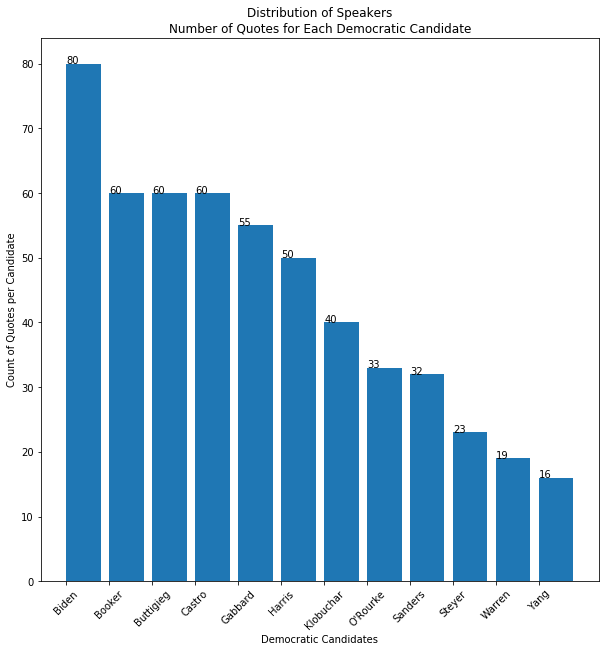

In [14]:
# Set Plot Size
plt.figure(figsize = (10,10))

# Give the plot a title
plt.title("Distribution of Speakers\nNumber of Quotes for Each Democratic Candidate")
plt.ylabel("Count of Quotes per Candidate")
plt.xlabel("Democratic Candidates")
# Rotate the tick labels and set their alignment.
plt.xticks(rotation=45)

# Turn the list of speaker last names into a pandas Series so we can use .value_counts().
# To make sure that the speakers and their quotes are in the same order I use .value_counts().index
speakers_quotes_df_training = pd.DataFrame({'Speakers':speaker_last_name,'Quotes':training_data})
spknames = speakers_quotes_df_training['Speakers'].unique()
sentencecounts = speakers_quotes_df_training['Speakers'].value_counts()

# Use a bar plot
plt.bar(spknames, sentencecounts, align = 'edge')

# Label the bar plot with the quote counts
for i in range(len(spknames)):
    plt.annotate(str(sentencecounts[i]), xy=(spknames[i], sentencecounts[i]))

#### There is a decent amount of variation in the distribution of observations, and we have fairly imbalanced classes. Below, I show the distribution of sentences, and in the annex I do a more detailed analysis on the number of words, and on the words vs sentences.

In [14]:
def split_quotes_to_sentences(quotes, speakers):
    
    # Split each quote into individual sentences by splitting on the period.
    # Now one quote is a sublist in a list, and each sentence is an item in each sublist
    sentences = [quotes[i].split('.') for i in range(len(quotes))]
    
    # Calculate the numer of sentences in each quote by looping through the sublists
    # and calculating the number of items
    num_sentences = [len(sentences[i]) for i in range(len(sentences))]

    # Find the speaker associated with each of the 528 quotes, and multiply that speaker by the number of
    # sentences in that quote. For example, if the first quote was by Joe Biden and had 3 sentences, we would
    # append 'Biden', 'Biden', 'Biden' to the speakers_list so that we can keep track of who said what sentence.
    speaker_list = []
    for i in range(len(speakers)):
        speaker_list.append([speakers[i]]*num_sentences[i])
        
    # Flatten the list of speakers to one long list
    speaker_list = [item for sublist in speaker_list for item in sublist]
    
    #Flatten the list of sentences
    sentences = [item for sublist in sentences for item in sublist]
    
    # Create dataframe out of the two lists
    speakers_quotes_df = pd.DataFrame({'Speakers':speaker_list, 'Sentence': sentences})
    
    # Based on how .split('.') works we whave lots of blank quotes, so I'll remove those before returning the df
    speakers_quotes_df = speakers_quotes_df.loc[speakers_quotes_df['Sentence'] != '' ]
    
    #return speaker_list, sentences
    return speakers_quotes_df
speakers_sentences_df_training = split_quotes_to_sentences(training_data, speaker_last_name)

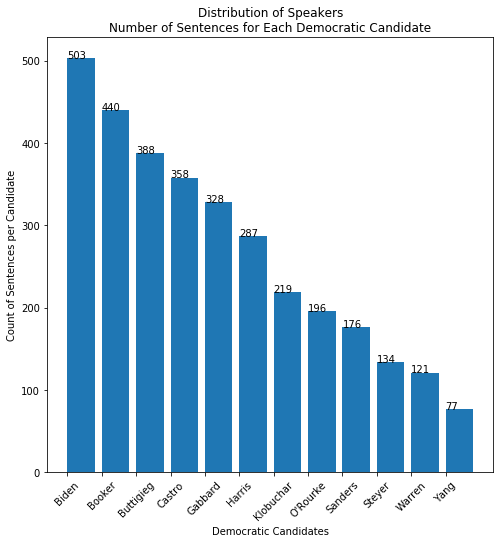

In [15]:
# Set Plot Size
plt.figure(figsize = (8,8))

# Give the plot a title
plt.title("Distribution of Speakers\nNumber of Sentences for Each Democratic Candidate")
plt.ylabel("Count of Sentences per Candidate")
plt.xlabel("Democratic Candidates")
# Rotate the tick labels and set their alignment.
plt.xticks(rotation=45)

# Turn the list of speaker last names into a pandas Series so we can use .value_counts().
# To make sure that the speakers and their quotes are in the same order I use .value_counts().index
spknames = speakers_sentences_df_training['Speakers'].unique()
sentencecounts = speakers_sentences_df_training['Speakers'].value_counts()

# Use a bar plot
plt.bar(spknames, sentencecounts, align = 'edge')

# Label the bar plot with the quote counts
for i in range(len(spknames)):
    plt.annotate(str(sentencecounts[i]), xy=(spknames[i], sentencecounts[i]))

#### There is quite a bit of variation in the number of sentences that each candidate has in the training dataset, from a max of 503 to a minimum of 77. This unequal representation could be an issue when trying to predict speakers. 
#### For our models it seems important to track both the number of words and number of observations/quotes for each speaker. For example, although Biden had 503 sentences, it is possible that they were shorter than the 77 sentences associated with Yang and Yang could have spoken more words, so his 'under representation' when it comes to the number of sentences/observations may be offset by the large number of words he spoke. 
#### I have plotted the average quote length, the total number of words associated with each speaker, along with a rescaled comparison of the total number of words to the total number of quotes and a boxplot of the distribution of quote lengths for each speaker. Rather than showing this here, I have put this in the annex section of this jupyter notebook.
#### Note: I chose not to split the quotes into sentences for the models because it didn't improve them, and made it difficult when outputting the predictions in the .txt file.

### 3 - Convert to Lower Case, Remove Punctuation, Remove Stopwords, Tokenize, and Remove Additional Stopwords from the Training Data.

In [16]:
# Function accepts a Series of quotes and then performs a variety of operations to clean them
def clean_quotes(Series):
    
    # CLEAN THE QUOTES
    
    # 1. Use apply function to the get the lower case of every letter in the string in the Series 
    cleaned_quotes = Series.apply(lambda x: x.lower())

    # 2. Loop through quotes and use regular expression to remove punctuation
    nopunc_quotes = []
    for i in cleaned_quotes:
        nopunc_quotes.append(re.findall('\w(?:[-\w]*\w)?', i)) # Using a regex I created from an assignment in 574

    # 3. Reset training_data_cleaned variable to the quotes without punctuation.
    # This removes apostrophes so threre will be left over letters like 's' and 'll' that the stopwords should remove
    cleaned_quotes = pd.Series(nopunc_quotes)

    # 4. Loop through each word in each quote to see if it is in the stopwords list. If not, append it to the nostopword_quotes list
    nostopword_quotes = []
    for i in range(len(cleaned_quotes)):
        nostopword_quotes.append([j for j in cleaned_quotes[i] if j not in stopwords])
    
    # Reset the training_data_cleaned variable to a Series
    cleaned_quotes = pd.Series(nostopword_quotes)
    
    return cleaned_quotes

In [17]:
# Set the nltk stopwords list to a new variable called 'stopwords'
stopwords = stopwords.words('english')
# Note: I plan on removing additional stop words after tokenizing.

In [18]:
# Call the clean_quotes() function and set the out put to the cleaned training_data variable
"""training_data_cleaned = clean_quotes(speakers_quotes_df_training['Sentence'])"""
training_data_cleaned = clean_quotes(pd.Series(training_data))

### 4 - Stem/Lemmatize Training Date, Show Sample of Changes, and Comment.

In [19]:
pstemmer = PorterStemmer()

#### I chose to stem the words instead of lemmatizing them because "lemmatisation requires correctly identifying the inded part of speech and meaning of a word in a sentence, as well as within the larger context surrounding that sentence" (Wikipedia, Lemmatisation). Because we have removed stopwords, it is almost much more difficult to identify the part of speech. Furthermore, as some of the quotes are responses to other quotes which the lemmatisation algorithm will not be aware of, I think stemming is a better approach.

In [20]:
def stem(Series):
    # Loop through each word in each quote and 'stem' it using the porter stemmer, 
    # then append it to the stemmed_words variable
    stemmed_words = []
    for quote in Series:
        stemmed_words.append([pstemmer.stem(word) for word in quote])
    return stemmed_words

In [21]:
stemmed_words = stem(training_data_cleaned)

In [22]:
# Compare the output for a few words
stemmed_words[0][0:5], training_data_cleaned[0][0:5], stemmed_words[25][5:10], training_data_cleaned[25][5:10],

(['refus', 'postpon', 'longer', 'take', 'climat'],
 ['refuse', 'postpone', 'longer', 'taking', 'climate'],
 ['beat', 'twice', 'abl', 'get', 'assault'],
 ['beat', 'twice', 'able', 'get', 'assault'])

In [23]:
# Compare a few more outputs
stemmed_words[500][20:25], training_data_cleaned[500][20:25]

(['govern', 'say', 'vision', 'economi', '21st'],
 ['government', 'saying', 'vision', 'economy', '21st'])

#### The porter stemmer shortens many words, especially those ending in 'e'. For example refuse, postpone, climate, and able were all had their 'e' chopped off. All of those words are roots, and could be other words like refusing, posponing, climatic. Able can be the suffix of other words like consumable, so that may be why it was cut off. 'Twice' did not have its 'e' chopped off, and it is not a root or suffix. Other changes includes things like changing the 'y' in economy to 'i' to that economic and economy would be the same word. Saying lost the 'ing' and removing the 'ing' makes a lot of sense and is likely very common. Another stemmed string of letters was 'ment' for government and there are many other words that have 'ment' as the ending like inducement, replacement, basement, merriment - so I looked up what 'ment' meant: "forming nouns expressing the means or result of an action." 

In [24]:
# Reset the training_data_cleaned variable to the stemmed words
training_data_cleaned = pd.Series(stemmed_words)

In [25]:
training_data_cleaned[0]

['refus',
 'postpon',
 'longer',
 'take',
 'climat',
 'chang',
 'lead',
 'world',
 'take',
 'climat',
 'chang',
 'look',
 'unit',
 'state',
 'america',
 'never',
 'singl',
 'solitari',
 'time',
 'set',
 'mind',
 'someth',
 'abl',
 'walk',
 'around',
 'head',
 'like',
 'woe',
 'best',
 'equip',
 'nation',
 'world',
 'take',
 'longer',
 'time',
 'postpon',
 'get',
 'move',
 'enorm',
 'enorm',
 'opportun',
 'get',
 'rid',
 'donald',
 'trump']

### 5 - Tokenize the Training Data Using Unigrams

In [26]:
# Currently have a Series and each value in the series is a list. 
# We need to 'flatten' it so that each Series is a string, not a list of words
def flatten(Series):
    full_quotes = []
    for quote in Series:
        full_quotes.append(' '.join([word for word in quote]))
    
    # Then turn that list of full_quotes into a series and return it
    return pd.Series(full_quotes)

In [27]:
# Pass the training_data_cleaned into the flatten function
training_data_cleaned = flatten(training_data_cleaned)

In [28]:
training_data_cleaned[0]

'refus postpon longer take climat chang lead world take climat chang look unit state america never singl solitari time set mind someth abl walk around head like woe best equip nation world take longer time postpon get move enorm enorm opportun get rid donald trump'

In [29]:
# Tokenize the words
# Create a vectorizer from sklearn. Default is unigrams.
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data - we don't want to fit on the testing data so we don't do fit_transform
vectorizer.fit(training_data_cleaned)

# Vectorize the quotes. Note: this creates a sparse matrix, # use .toarray() if you want a dense matrix. 
X = vectorizer.transform(training_data_cleaned) 

# Get a list of the 'tokens'
words = vectorizer.get_feature_names()

In [30]:
print("There are {} unique tokens in my vocabulary, and the shape of my sparse matrix is {}".format(
len(words), X.toarray().shape))

There are 3469 unique tokens in my vocabulary, and the shape of my sparse matrix is (528, 3469)


#### I have more features than observations which is an issue, but for now, I will not set a min or max word counts, because I want to see what these words actually are. Because the corpus is very limited (both in size and in content) there are likely words that appear in many of the quotes. However, I still want to see what these words are. I want to first take a look at them because it is possible they appear often but only for one candidate, something like a catch phrase that would help identify a candidate. Let's take a look at the most popular words.

In [31]:
# Return words that occurr more than n times

# Calculate the sum over each column and reshape it the resulting matrix to an array
word_counts = np.sum(X[:,:], axis = 0)
word_counts = np.array(word_counts).reshape(-1)

# Return index positions for values over a certain threshold
over_n_occurrences_index = np.where(word_counts > 150)
# Use the index positions to return values from the word list
[words[i] for i in over_n_occurrences_index[0]]

['america',
 'american',
 'countri',
 'get',
 'go',
 'know',
 'like',
 'make',
 'need',
 'one',
 'peopl',
 'presid',
 'right',
 'say',
 'talk',
 'think',
 'us',
 'want',
 'way',
 'work',
 'would']

In [32]:
# Return the n most frequently used words from the arrray (thanks to stack overflow for the .argsort() method)

# Calculate the sum over each column, reshape the resulting matrix to an array, and use .argsort() to return
# sort the array and return the index positions for the top n values
top_n_wordindices = np.array(np.sum(X[:,:], axis = 0)).reshape(-1).argsort()[-20:][::-1]

# Use the index positions to return values from the word list
top_n_words = [words[i] for i in top_n_wordindices]
top_n_words

['peopl',
 'go',
 'presid',
 'countri',
 'get',
 'make',
 'need',
 'think',
 'want',
 'american',
 'one',
 'right',
 'us',
 'work',
 'would',
 'like',
 'say',
 'way',
 'america',
 'know']

#### From a first glance, the words in both of these lists look like we could throw them away because they will likely be used very frequently (america, american, president, country, people) or because they don't carry much meaning/are commonly used words (get, say, us, want). However, thinking back to the 2016 elections in which one slogan was 'make america great again' I am hesitant to throw these away. I am going to hand-select some of the words from the most popular to get rid of. Before I do that though, I'll look at words that occur only 1 time. The risk with a word only occuring one time is that our model might think it is a sure fire way to predict a candidate, but then that same word might appear in the test set.

In [33]:
# Return index positions for values under a certain threshold
over_n_occurrences_index = np.where(word_counts == 1)
# Use the index positions to return values from the word list
[words[i] for i in over_n_occurrences_index[0]]

['00',
 '040',
 '05',
 '1000',
 '12th',
 '130',
 '140',
 '1500',
 '1619',
 '1776',
 '1850',
 '18th',
 '1963',
 '1973',
 '1988',
 '1995',
 '1st',
 '2002',
 '2008',
 '2011',
 '2013',
 '2017',
 '2019',
 '2028',
 '2035',
 '20th',
 '250',
 '25th',
 '26',
 '27',
 '28',
 '32',
 '36',
 '39',
 '43',
 '442',
 '48',
 '4th',
 '53',
 '55',
 '58',
 '5th',
 '640',
 '69',
 '71',
 '715',
 '75',
 '7th',
 '800',
 '83',
 '9000',
 '92',
 '99',
 'abc',
 'aberr',
 'abraham',
 'academ',
 'acceler',
 'accid',
 'accord',
 'accus',
 'adema',
 'admir',
 'admit',
 'advanc',
 'advic',
 'aftermath',
 'aggress',
 'agribusi',
 'airlift',
 'airport',
 'akin',
 'alcohol',
 'allig',
 'aloha',
 'altar',
 'alter',
 'alum',
 'ambassadorship',
 'ambul',
 'amok',
 'anem',
 'anger',
 'anguish',
 'annoy',
 'anthem',
 'apiec',
 'apocalypt',
 'apologist',
 'app',
 'appal',
 'appar',
 'applic',
 'arbitrari',
 'arizona',
 'arkansa',
 'armor',
 'arrang',
 'arrog',
 'aspect',
 'assassin',
 'assign',
 'associ',
 'assum',
 'atatiana',


#### I plot some histograms of the distribution of the number of occurrences of the words in the Annex.

#### I was not expecting this many words to have been spoken only one time, especially since many of them seem like pretty common words you would hear at a Presidential Debate (proof, protest, libya, libertarian, lincoln, logic). I also noticed some mistakes in the transcription; I believe 'klobushar' referes to candidate Klobuchar and 'kamalaharri' refers to candidate Kamala Harris. For now, I won't remove the words that appear only once...

In [34]:
# Choose additional stopwords
additional_stopwords = ['peopl', 'get', 'us', 'like', 'say', 'would']

In [35]:
# 'Relistify' the quotes so we can remove stopwords
list_words = [] 
for i in range(len(training_data_cleaned)):
    list_words.append(training_data_cleaned[i].split())
    
training_data_cleaned = pd.Series(list_words)

In [36]:
# 4. Loop through each word in each quote to see if it is in the stopwords list. 
# If not, append it to the without_additional_stopwords list
without_additional_stopwords = []

for i in range(len(training_data_cleaned)):
    without_additional_stopwords.append([j for j in training_data_cleaned[i] if j not in additional_stopwords])

#### Now I need to flatten the list again, refit the CountVectorizer and tokenize the words again

In [37]:
training_data_cleaned = flatten(without_additional_stopwords)

In [38]:
# Tokenize the words
# Create a vectorizer from sklearn. Default is unigrams.
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data - we don't want to fit on the testing data so we don't do fit_transform
vectorizer.fit(training_data_cleaned)

# Vectorize the quotes. Note: this creates a sparse matrix, # use .toarray() if you want a dense matrix. 
X = vectorizer.transform(training_data_cleaned) 

# Get a list of the 'tokens'
words = vectorizer.get_feature_names()

In [39]:
len(words)

3464

#### We can see I removed 5 words from our bag of words matrix

### 6 - Process the Test Data in an Identical Manner to Training Data. Show that Number of Features are Identical.

In [40]:
# First split the quotes into sentences. I need to pass in a speaker name to the function that splits quotes
# into sentences, so I will pass in an an array of strings with the 'Unknown' label
speaker_names_test = ['Unknown']*len(test_data)
speakers_quotes_df_test = split_quotes_to_sentences(test_data, speaker_names_test)
speakers_quotes_df_test.head()

,Speakers,Sentence
0,Unknown,"You know, I served under General Dunford, way ..."
1,Unknown,"And today, September 12th, 2019 means that t..."
2,Unknown,We have got to put an end to endless war
3,Unknown,And the way we do it is see to it that that c...
4,Unknown,"Let me say something else, because if there’s..."


In [41]:
# Send the test data through the clean_quotes function
test_data_cleaned = clean_quotes(pd.Series(test_data))

In [42]:
# Send the cleaned test data through the stem function
test_data_cleaned = pd.Series(stem(test_data_cleaned))

In [43]:
# Remove the additional stopwords
without_additional_stopwords = []

for i in range(len(test_data_cleaned)):
    without_additional_stopwords.append([j for j in test_data_cleaned[i] if j not in additional_stopwords])

test_data_cleaned = pd.Series(without_additional_stopwords)

In [44]:
# Send the cleaned and stemmed test data to be 'flattened' and turned into a string
test_data_cleaned = flatten(test_data_cleaned)

In [45]:
# Create the X_test array from the vectorizer fit on the training data
X_test = vectorizer.transform(test_data_cleaned)

In [46]:
X_test.toarray().shape, X.toarray().shape

((111, 3464), (528, 3464))

#### We can see that the test data has 111 observations and the same number of columns that correspond to the vocabulary size as the training set because it was fit on the training set. 
#### Out of curiosity, I'm going check the vocab size of the test dataset - this section will live in the Annex.

# Part 2: Supervised Learning

### 7 - Feature Engineering

#### Bigrams

In [47]:
# Tokenize the words using bigrams
# Create a vectorizer from sklearn.
bigram_vectorizer = CountVectorizer(ngram_range = (1,2))

# Fit the vectorizer on the training data - we don't want to fit on the testing data so we don't do fit_transform
bigram_vectorizer.fit(training_data_cleaned)

# Vectorize the quotes. Note: this creates a sparse matrix, # use .toarray() if you want a dense matrix. 
X_bigrams = bigram_vectorizer.transform(training_data_cleaned) 

# Get a list of the 'tokens'
bigram_words = bigram_vectorizer.get_feature_names()

#### TF-IDF

In [48]:
# Tokenize the words using term frequency inverse document frequency
# Create a vectorizer from sklearn.
tfidf_vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data - we don't want to fit on the testing data so we don't do fit_transform
tfidf_vectorizer.fit(training_data_cleaned)

# Vectorize the quotes. Note: this creates a sparse matrix. Use .toarray() if you want a dense matrix. 
X_tfidf = tfidf_vectorizer.transform(training_data_cleaned) 

# Get a list of the 'tokens'
tfidf_words = tfidf_vectorizer.get_feature_names()

#### Min Word Counts > 1

In [49]:
# Tokenize the words, excluding words that only appear once
highcounts_vectorizer = CountVectorizer(min_df = 2)

# Fit the vectorizer on the training data = we don't want to fit on the testing data so we don't do fit_transform
highcounts_vectorizer.fit(training_data_cleaned)

# Vecotrize the quotes. This creates a sparse matrix
X_highcounts = highcounts_vectorizer.transform(training_data_cleaned)

# Get a list of the 'tokens'
highcounts_words = highcounts_vectorizer.get_feature_names()

X_highcounts.shape

(528, 2035)

#### There are still more features than observations even when excluding words that only appear once. Maybe a better way to do dimensionality reduction would be PCA.
#### PCA

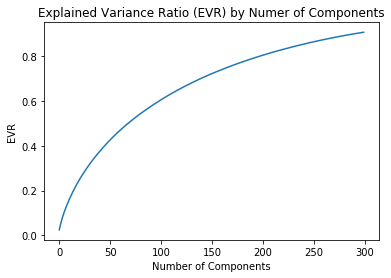

In [50]:
pca = PCA(n_components=300)
pca.fit(X.toarray())
evr = pca.explained_variance_ratio_
plt.title('Explained Variance Ratio (EVR) by Numer of Components')
plt.xlabel('Number of Components')
plt.ylabel('EVR')
plt.plot(np.cumsum(evr))

#### Very rough eyeballing it I am going to go with 200 components. The real bend looks like it is at about 50, but that only explains 40% of the variance which may be too little.

In [51]:
pca = PCA(n_components = 200)
X_reduced = pca.fit_transform(X.toarray())
X_reduced.shape

(528, 200)

#### Finally we have gotten rid of the curse of dimensionality.

### 8 - Build a Regularized Logistic Regression Model and Comment on Performance

#### First I'll start with creating a couple of helper functions to make comparisons of different models much easier and systematic. The functions include a way to calculate Precision, Recall, and F-score since we this is a classification problem and a good way to measure results; an easy way to loop through different hyperparameters and return outputs; and a way to plot  the confusion matrix.

In [52]:
# Create a function that calculates scores from a confusion matrix
def scores(conf_mat):
    # Count up the number of predicted values and true values for each candidate
    true_counts = [conf_mat[i,:] for i in range(len(conf_mat))]
    predicted_counts = [conf_mat[:,i] for i in range(len(conf_mat))]

    # Precision: number of correct predictions out of all predictions
    precision = [np.sum(conf_mat[i,i])/np.sum(predicted_counts[i]) for i in range(len(conf_mat))]

    # Recall: number of correct predictions out of total number of observations
    recall = [np.sum(conf_mat[i,i])/np.sum(true_counts[i]) for i in range(len(conf_mat))]

    # Harmonic Mean of precision and recall
    fscore = [2*((precision[i]*recall[i])/(precision[i]+recall[i])) for i in range(len(conf_mat))]
    
    return {'Precision':precision, 'Recall':recall, 'F-score':fscore}

In [53]:
# Create a function that takes in many models, and returns cross-validated predictions for each model
def cross_validated_many_preds(models, X):
    """Should be model agnostic"""
    cv_y_preds = []
    for i in models:
        cv_y_preds.append(cross_val_predict(i, X, y, cv = 5))

    conf_mat_preds = []
    for i in cv_y_preds:
        conf_mat_preds.append(confusion_matrix(y, i, labels = pd.Series(y).unique()))
    
    return conf_mat_preds

In [54]:
# Create a function that returns a dataframe of scores and hyperparam values
def many_model_scores(conf_mat_preds, hyperparams, hyperparam_name):
    """conf_mats will be a list of multiple model predictions
       hyperparams are the values of the hyperparam we are tuning, and 
       hyperparam_name is the name of the hyperparameter we are tuning."""

    # Loop through the predictions, calculate scores, and store them
    Candidates = []
    recalls = []
    precisions = []
    fscores = []
    hyperp = []
    for i in range(len(conf_mat_preds)):
        Candidates.append(pd.Series(y).unique())
        recalls.append(scores(conf_mat_preds[i])['Recall'])
        precisions.append(scores(conf_mat_preds[i])['Precision'])
        fscores.append(scores(conf_mat_preds[i])['F-score'])
        hyperp.append([hyperparams[i]]*12)
        
    
    df = pd.DataFrame({'Candidate': [item for sublist in Candidates for item in sublist],
                      'Recall': [item for sublist in recalls for item in sublist],
                      'Precision': [item for sublist in precisions for item in sublist],
                      'F-Score': [item for sublist in fscores for item in sublist],
                       hyperparam_name: [item for sublist in hyperp for item in sublist]})
    return df

In [55]:
# Create a function that plots the confusion matrix
def plot_confusion_matrix(cm, classes, title):
    # Set plot size
    fig, ax = plt.subplots(figsize = (9,9))
    im = ax.imshow(cm[::-1], cmap = 'Blues', 
               aspect = 'equal', extent = (-0.5, 11.5, -0.5, 11.5))

    plt.title('k')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, cm[i,j], 
                       ha="center", va="center", color="black", fontsize = 14)    
        
    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

In [56]:
# Set the y value to the names of the speakers
y = speaker_last_name

# I am going to use both lasso and ridge regularization eventually
logreg = LogisticRegression(penalty = 'l2', multi_class = 'ovr', C = .2, solver = 'liblinear').fit(X,y)

# Make predictions - logpreds is predictions on the training set, cv_y_pred is cross validated predictions
logpreds = logreg.predict(X)
cv_y_pred = cross_val_predict(logreg, X, y, cv = 5)

In [57]:
# Tune the hyperparameter C
logregmods_ridge = []
for i in np.arange(.001,1,.1):
    logregmods_ridge.append(LogisticRegression(penalty = 'l2', multi_class = 'ovr', solver = 'liblinear', C=i).fit(X_reduced,y))


# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_ridge = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_ridge, X_reduced),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_ridge.head()    

,Candidate,Recall,Precision,F-Score,C
0,Biden,0.666667,0.500000,0.571429,0.001
1,Booker,0.320000,0.410256,0.359551,0.001
2,Buttigieg,0.433333,0.382353,0.406250,0.001
3,Castro,0.173913,0.800000,0.285714,0.001
4,Gabbard,0.312500,0.625000,0.416667,0.001


#### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Now we can build and fit the logistic regression models. Because we don't have a test set to compare to, I'll be using cross-validation to tune hyperparameters.

In [58]:
# Tune the hyperparameter C
logregmods_ridge = []
for i in np.arange(.001,1,.1):
    logregmods_ridge.append(LogisticRegression(penalty = 'l2', multi_class = 'ovr', solver = 'liblinear', C=i).fit(X,y))

In [59]:
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_ridge = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_ridge, X),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_ridge.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,C
0,Biden,0.483333,0.547170,0.513274,0.001
1,Booker,0.080000,0.666667,0.142857,0.001
2,Buttigieg,0.416667,0.290698,0.342466,0.001
3,Castro,0.000000,NaN,NaN,0.001
4,Gabbard,0.000000,NaN,NaN,0.001


In [60]:
# Group the results by the hyperparameter values and caluclate mean scores, the nplot
def plot_f_score(grouped_model_results, hyperparam, title):
    # Plot the results for mean F-Scores
    plt.title(title)
    plt.xlabel(hyperparam + 'Value')
    plt.ylabel('Avg F-Score')
    plt.plot(hyperparam, 'F-Score', data = grouped_model_results)

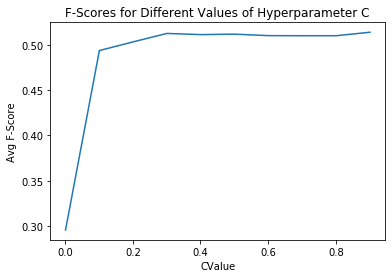

In [61]:
grouped_results_ridge = results_ridge.groupby('C', as_index = False).mean()
plot_f_score(grouped_results_ridge, 'C', 'F-Scores for Different Values of Hyperparameter C')

#### Looks like the highest F-Score Values are with larger values of C. I'll select the highest F-Score value and choose the setting for C and that level, select the model that corresponds to that C-Value, create a cross-validated confusion matrix and plot it.

In [62]:
# Show the C value that corresponds to the highest F-Score
grouped_results_ridge[grouped_results_ridge['F-Score'] == grouped_results_ridge['F-Score'].max()]

,C,Recall,Precision,F-Score
9,0.901,0.488426,0.583297,0.513731


In [63]:
# Find the model that corresponds to that C value that produced the 'best' model
# Show the C value that corresponds to the highest F-Score
bestparam_r = grouped_results_ridge[grouped_results_ridge['F-Score'] == grouped_results_ridge['F-Score'].max()]
bestparam_r

,C,Recall,Precision,F-Score
9,0.901,0.488426,0.583297,0.513731


In [64]:
# Find the model that corresponds to that C value that produced the 'best' model
bestmod_r = logregmods_ridge[bestparam_r.index.values[0]]
bestmod_r

LogisticRegression(C=0.901, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [65]:
# Use that model to generate cross-validated predictions
cv_y_pred = cross_val_predict(logregmods_ridge[bestparam_r.index.values[0]], X, y, cv = 5)

# Create a multi-class confusion_matrix from those preidctions
conf_mat = confusion_matrix(y, cv_y_pred, labels = pd.Series(y).unique())

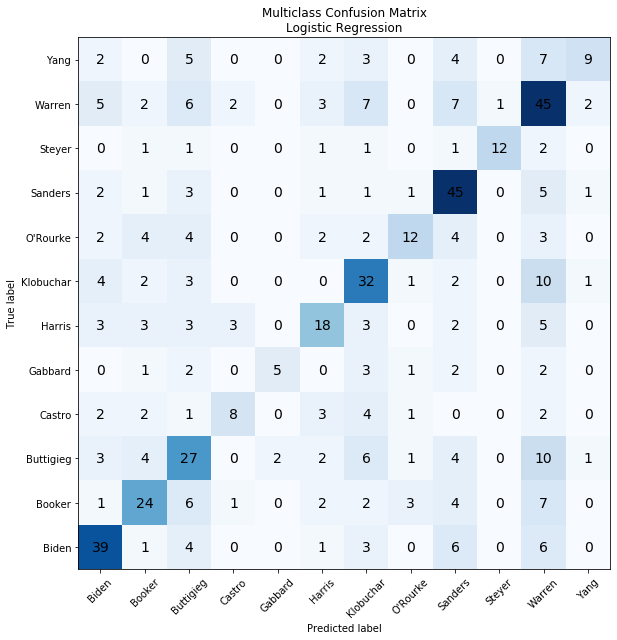

In [66]:
# Plot the confusion matrix
plot_confusion_matrix(conf_mat, 
                      classes=np.array(pd.Series(y).unique()),
                      title = 'Multiclass Confusion Matrix\nLogistic Regression')

#### I am going to switch from ridge regression to lasso regression to see if lasso can help us with feature selection. This may be helpful in this case because I did not remove many words that occur frequently.

In [67]:
# Tune the hyperparameter C with a different penalty, lasso.
logregmods_lasso = []
for i in np.arange(.001,1,.1):
    logregmods_lasso.append(LogisticRegression(penalty = 'l1', multi_class = 'ovr', solver = 'liblinear', C=i).fit(X,y))

In [68]:
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_lasso = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_lasso, X),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_lasso.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Candidate,Recall,Precision,F-Score,C
0,Biden,1.0,0.113636,0.204082,0.001
1,Booker,0.0,NaN,NaN,0.001
2,Buttigieg,0.0,NaN,NaN,0.001
3,Castro,0.0,NaN,NaN,0.001
4,Gabbard,0.0,NaN,NaN,0.001


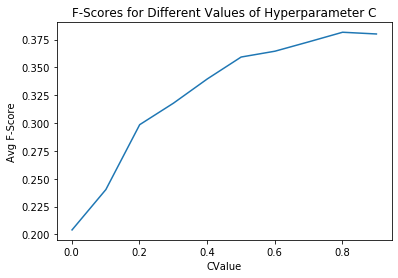

In [69]:
grouped_results_lasso = results_lasso.groupby('C', as_index = False).mean()
plot_f_score(grouped_results_lasso, 'C', 'F-Scores for Different Values of Hyperparameter C')

In [70]:
# Show the C value that corresponds to the highest F-Score
bestparam_l = grouped_results_lasso[grouped_results_lasso['F-Score'] == grouped_results_lasso['F-Score'].max()]
bestparam_l

,C,Recall,Precision,F-Score
8,0.801,0.370658,0.407134,0.381543


In [71]:
# Find the model that corresponds to that C value that produced the 'best' model
bestmod_l = logregmods_lasso[bestparam_l.index.values[0]]
bestmod_l

LogisticRegression(C=0.801, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
# Use that model to generate cross-validated predictions
cv_y_pred = cross_val_predict(logregmods_lasso[bestparam_l.index.values[0]], X, y, cv = 5)

# Create a multi-class confusion_matrix from those preidctions
conf_mat = confusion_matrix(y, cv_y_pred, labels = pd.Series(y).unique())

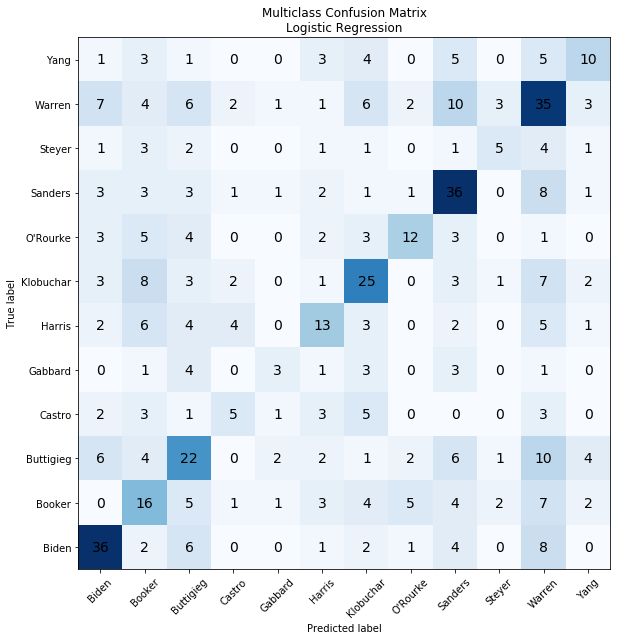

In [73]:
# Plot the confusion matrix
plot_confusion_matrix(conf_mat, 
                      classes=np.array(pd.Series(y).unique()),
                      title = 'Multiclass Confusion Matrix\nLogistic Regression')

#### Lasso performed much worse than ridge regression at least on the F-score metric. The best models were those with ridge regression and a high setting for the C hyperparameter (weaker regularization). 
#### Let's take a closer look at the classes and scores for those classes for the 'best', which was the ridge regression model.

In [74]:
results_ridge.loc[results_ridge['C'] == bestparam_r['C'].values[0]]

,Candidate,Recall,Precision,F-Score,C
108,Biden,0.650000,0.619048,0.634146,0.901
109,Booker,0.480000,0.533333,0.505263,0.901
110,Buttigieg,0.450000,0.415385,0.432000,0.901
111,Castro,0.347826,0.571429,0.432432,0.901
112,Gabbard,0.312500,0.714286,0.434783,0.901
113,Harris,0.450000,0.514286,0.480000,0.901
114,Klobuchar,0.581818,0.477612,0.524590,0.901
115,O'Rourke,0.363636,0.600000,0.452830,0.901
116,Sanders,0.750000,0.555556,0.638298,0.901
117,Steyer,0.631579,0.923077,0.750000,0.901


#### I want to understand what influences a strong probability for a prediction, so I start by selecting observations where the highest probability was very low, and others where the highest probability was very high, and then print out some of those observations. This section will live in the Annex.

### 9 - Build a Regularized Tree-Based Model and Comment on Performance

In [75]:
# Base tree with some pre-pruning
decisiontree = tree.DecisionTreeClassifier(max_depth = 6)

In [76]:
# Tune the hyperparameter Number of Estimators
bagging_mods = []
for i in np.arange(1,200,20):
    bagging_mods.append(BaggingClassifier(base_estimator = decisiontree, n_estimators=i).fit(X,y))

In [77]:
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
bagging_results = many_model_scores(conf_mat_preds = cross_validated_many_preds(bagging_mods, X),
                  hyperparams = np.arange(1,200,20), 
                  hyperparam_name = 'Number of Estimators')

bagging_results.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Candidate,Recall,Precision,F-Score,Number of Estimators
0,Biden,0.300000,0.156522,0.205714,1
1,Booker,0.020000,0.500000,0.038462,1
2,Buttigieg,0.166667,0.476190,0.246914,1
3,Castro,0.000000,0.000000,NaN,1
4,Gabbard,0.000000,NaN,NaN,1


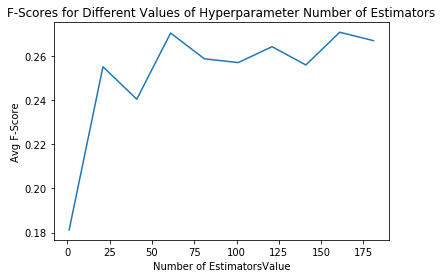

In [78]:
# Group results by the number of estimators and calculate mean scores
grouped_results_bagging = bagging_results.groupby('Number of Estimators', as_index = False).mean()
plot_f_score(grouped_results_bagging, 'Number of Estimators', 'F-Scores for Different Values of Hyperparameter Number of Estimators')

In [79]:
# Show the Num_estimators value that corresponds to the highest F-Score
bestparam_bag = grouped_results_bagging[grouped_results_bagging['F-Score'] == grouped_results_bagging['F-Score'].max()]
bestparam_bag

,Number of Estimators,Recall,Precision,F-Score
8,161,0.209574,0.353814,0.270701


In [80]:
# Find the model that corresponds to that C value that produced the 'best' model
bestmod_bag = bagging_mods[bestparam_bag.index.values[0]]
bestmod_bag

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                        criterion='gini',
                                                        max_depth=6,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort=False,
                                                        random_state=None,
                                                        splitter='best'),
       

In [81]:
# Use that model to generate cross-validated predictions
cv_y_pred = cross_val_predict(bagging_mods[bestparam_bag.index.values[0]], X, y, cv = 5)

# Create a multi-class confusion_matrix from those preidctions
conf_mat = confusion_matrix(y, cv_y_pred, labels = pd.Series(y).unique())

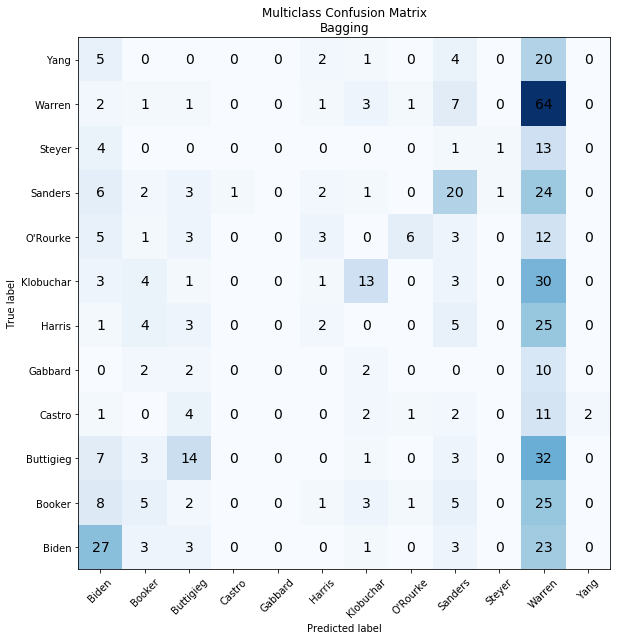

In [82]:
plot_confusion_matrix(conf_mat, 
                      classes=np.array(pd.Series(y).unique()),
                      title = 'Multiclass Confusion Matrix\nBagging')

#### I chose the bagging ensemble method for my tree-based model. I actually started with a boosting model and thought it would perform better because boosting can help reduce bias, but I think because I am using cross-validation that I needed something to reduce variance so that I could 'predict' the other n-folds in each cross-validation loop (the bagging method performs almost twice as well as boosting in terms of an F-score). The model seems to overwhelmingly predict Warren, who has the most number of words in the data. The flip side of that is that the candidates with the fewest number of words - Castor, Steyer, and Gabbard are predicted very few times - 1, 0, and 2 respectively. 

In [83]:
bagging_results.loc[bagging_results['Number of Estimators'] == bestparam_bag['Number of Estimators'].values[0]]

,Candidate,Recall,Precision,F-Score,Number of Estimators
96,Biden,0.466667,0.417910,0.440945,161
97,Booker,0.060000,0.150000,0.085714,161
98,Buttigieg,0.183333,0.354839,0.241758,161
99,Castro,0.000000,NaN,NaN,161
100,Gabbard,0.000000,NaN,NaN,161
101,Harris,0.075000,0.176471,0.105263,161
102,Klobuchar,0.236364,0.481481,0.317073,161
103,O'Rourke,0.242424,0.666667,0.355556,161
104,Sanders,0.333333,0.408163,0.366972,161
105,Steyer,0.105263,0.666667,0.181818,161


#### This is a pretty sad model. It performed the best for Biden with an F-Score of around .38. 

### 10 - Build any Model and Comment on Process & Results

#### I am choosing the "Complement Naive Bayes (CNB) which is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets" (sklearn documentation, link found in sources). Naive Bayes has worked well for me in the past for text classification and is incredibly fast compared to ensemble methods, and has been proven to work well in the real of text classification and bag of words (Towards Data Science). Because we have relatively imbalanced classes, I thought a CNB would work better. I tuned the alpha hyperparameter which is a smoothing parameter, to help deal with 'zero probability'. Dealing with zero probability is important in this context because there are words that only appear once or twice, so they will be attributable to only one speaker. For example, if in the training dataset the word 'law' only appears once and was spoken by Gabbard, then in the test dataset if the word 'law' appears the model will add a higher probability to predict Gabbard because for that word there will be a probability of 0 that the speaker was Biden.

In [84]:
# Tune the hyperparameter alpha. Using quotecounts as the priors (although this doesn't seem to affect things)
cnb_mods = []
for i in np.arange(.01,5,.5):
    cnb_mods.append(ComplementNB(class_prior = sentencecounts ,alpha=i).fit(X,y))

In [85]:
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_cnb = many_model_scores(conf_mat_preds = cross_validated_many_preds(cnb_mods, X),
                  hyperparams = np.arange(.01,5,.5), 
                  hyperparam_name = 'Alpha')

results_cnb.head()

,Candidate,Recall,Precision,F-Score,Alpha
0,Biden,0.466667,0.474576,0.470588,0.01
1,Booker,0.340000,0.435897,0.382022,0.01
2,Buttigieg,0.566667,0.485714,0.523077,0.01
3,Castro,0.043478,0.055556,0.048780,0.01
4,Gabbard,0.375000,0.333333,0.352941,0.01


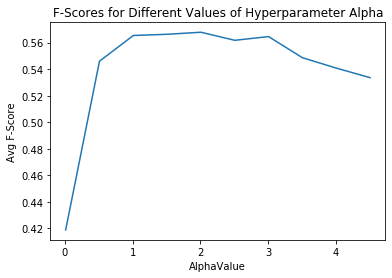

In [86]:
# Group the results by the Alpha value and calculate mean scores
grouped_results_cnb = results_cnb.groupby('Alpha', as_index = False).mean()
plot_f_score(grouped_results_cnb, 'Alpha', 'F-Scores for Different Values of Hyperparameter Alpha')

In [87]:
# Show the Alpha value that corresponds to the highest F-Score
bestparam_cnb = grouped_results_cnb[grouped_results_cnb['F-Score'] == grouped_results_cnb['F-Score'].max()]
bestparam_cnb

,Alpha,Recall,Precision,F-Score
4,2.01,0.563796,0.590842,0.567804


In [88]:
# Find the model that corresponds to that C value that produced the 'best' model
bestmod_cnb = cnb_mods[bestparam_cnb.index.values[0]]
bestmod_cnb

ComplementNB(alpha=2.01,
             class_prior=Warren       503
Biden        440
Klobuchar    388
Buttigieg    358
Sanders      328
Booker       287
Harris       219
O'Rourke     196
Yang         176
Castro       134
Steyer       121
Gabbard       77
Name: Speakers, dtype: int64,
             fit_prior=True, norm=False)

In [89]:
# Use that model to generate cross-validated predictions
cv_y_pred = cross_val_predict(cnb_mods[bestparam_cnb.index.values[0]], X, y, cv = 5)

# Create a multi-class confusion_matrix from those preidctions
conf_mat = confusion_matrix(y, cv_y_pred, labels = pd.Series(y).unique())

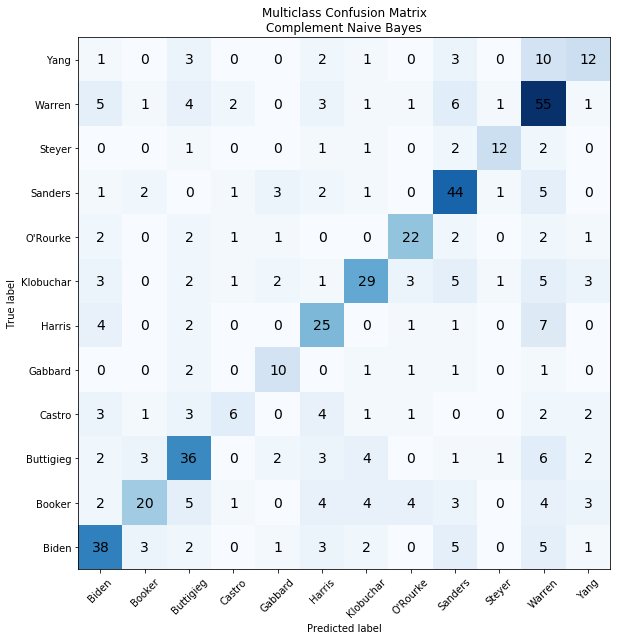

In [90]:
plot_confusion_matrix(conf_mat, 
                      classes=np.array(pd.Series(y).unique()),
                      title = 'Multiclass Confusion Matrix\nComplement Naive Bayes')

### 11 - Compare Performance of 3 Classifiers to Determine Strongest and Weakest
#### I have 4 models to compare (a fifth model is in the Annex): The best model from Bagging, Ride Regression, Lasso Regression, and Complement Naive Bayes. I use the F-Score results from 5-fold cross-validation to compare these models. I chose F-score because it is a harmonic mean of preicision and recall, two measures that give a better look at the overall classification strength of a model (compare this to accuracy, where in cases of one dominant class the model can always predict that class and do well). Our training set had reasonably balanced data - the most frequently occuring class only occured around 15% of the time, so a model that ony predicted the majority class would perform poorly. Still F-Score gives us a better feel for how the model performs overall because it takes into account correct predictions for a class out of total predictions for that class and correct predictions for a class out of the total actual labels of that class. 
#### Although the F-score is convenient, it has a drawback in that it gives equal weight to precision and recal, but in some cases precision may be more important than recall, and vice versa. Because we are not dealing with sick patients (or predicting if someone has a communicable disease) I don't see a reason to prefer precision over recall or vice versa, so will stick with F-score.

In [91]:
print("The F-Score for the best models in order from weakest to strongest is:\nBagging Model: {}\n"
    "Logistic Regression Lasso Model:{}\nLogistic Regression Ridge Model: {}\n"
     "Complement Naive Bayes Model: {}".format(bestparam_bag['F-Score'].values[0],
                                              bestparam_l['F-Score'].values[0],
                                              bestparam_r['F-Score'].values[0],
                                              bestparam_cnb['F-Score'].values[0]))

The F-Score for the best models in order from weakest to strongest is:
Bagging Model: 0.27070081127867307
Logistic Regression Lasso Model:0.3815432668611188
Logistic Regression Ridge Model: 0.5137314623374191
Complement Naive Bayes Model: 0.5678037038918541


### ---- RETURNING TO QUESTION 7 ----
#### I build, score, and produce graphs for four additional inputs with different engineered features (bigrams, tfidf, min word count >1, and PCA). All of these graphs get a little busy, and many of these different inputs don't help, so all except for bigrams live in the annex, with additional analysis there.

### Run the same models but bigrams as inputs instead of unigrams.

In [92]:
# Tune the hyperparameter C
logregmods_ridge_bigram = []
for i in np.arange(.001,1,.1):
    logregmods_ridge_bigram.append(LogisticRegression(penalty = 'l2', multi_class = 'ovr', C=i, solver = 'liblinear').fit(X_bigrams,y))

results_ridge_bigram = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_ridge_bigram, X_bigrams),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_ridge_bigram.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,C
0,Biden,0.533333,0.592593,0.561404,0.001
1,Booker,0.120000,0.545455,0.196721,0.001
2,Buttigieg,0.416667,0.308642,0.354610,0.001
3,Castro,0.000000,NaN,NaN,0.001
4,Gabbard,0.062500,1.000000,0.117647,0.001


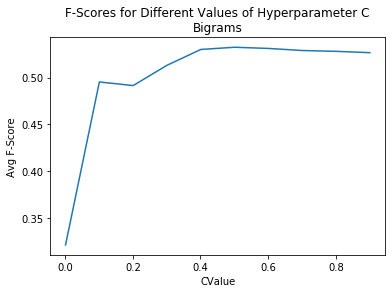

In [93]:
# Group the results by the C value and calculate mean scores
grouped_results_ridge_bigram = results_ridge_bigram.groupby('C', as_index = False).mean()
plot_f_score(grouped_results_ridge_bigram, 'C', 'F-Scores for Different Values of Hyperparameter C\nBigrams')

#### Doesn't look better than the unigram ridge regression.
#### Bagging with bigrams.

In [94]:
# Tune the hyperparameter Number of Estimators
bagging_mods_bigram = []
for i in np.arange(1,200,20):
    bagging_mods_bigram.append(BaggingClassifier(base_estimator = decisiontree, n_estimators=i).fit(X_bigrams,y))
    
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
bagging_results_bigram = many_model_scores(conf_mat_preds = cross_validated_many_preds(bagging_mods_bigram, X_bigrams),
                  hyperparams = np.arange(1,200,20), 
                  hyperparam_name = 'Number of Estimators')

bagging_results_bigram.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,Number of Estimators
0,Biden,0.350000,0.184211,0.241379,1
1,Booker,0.040000,0.166667,0.064516,1
2,Buttigieg,0.083333,0.200000,0.117647,1
3,Castro,0.000000,0.000000,NaN,1
4,Gabbard,0.000000,0.000000,NaN,1


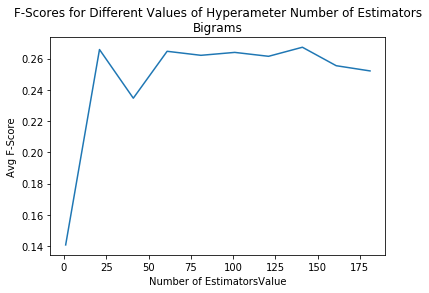

In [95]:
# Group the results by the C value and calculate mean scores
grouped_results_bagging_bigram = bagging_results_bigram.groupby('Number of Estimators', as_index = False).mean()
plot_f_score(grouped_results_bagging_bigram, 'Number of Estimators', 'F-Scores for Different Values of Hyperameter Number of Estimators\nBigrams')

#### Not much, if any, improvement over unigrams.
#### CNB model with bigrams.

In [96]:
# Tune the hyperparameter n_estimators. Using quotecounts as the priors (although this doesn't seem to affect things)
cnb_mods_bigram = []
for i in np.arange(.01,5,.5):
    cnb_mods_bigram.append(ComplementNB(class_prior = sentencecounts ,alpha=i).fit(X_bigrams,y))

# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_cnb_bigram = many_model_scores(conf_mat_preds = cross_validated_many_preds(cnb_mods_bigram, X_bigrams),
                  hyperparams = np.arange(.01,5,.5), 
                  hyperparam_name = 'Alpha')

results_cnb_bigram.head()

,Candidate,Recall,Precision,F-Score,Alpha
0,Biden,0.583333,0.555556,0.569106,0.01
1,Booker,0.520000,0.619048,0.565217,0.01
2,Buttigieg,0.516667,0.620000,0.563636,0.01
3,Castro,0.217391,0.178571,0.196078,0.01
4,Gabbard,0.500000,0.363636,0.421053,0.01


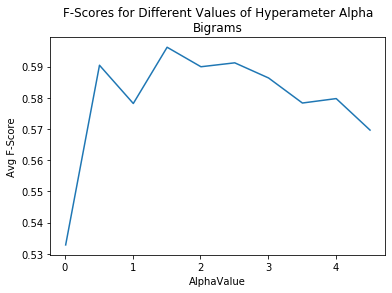

In [97]:
# Group the results by the C value and calculate mean scores
grouped_results_cnb_bigram = results_cnb_bigram.groupby('Alpha', as_index = False).mean()
plot_f_score(grouped_results_cnb_bigram, 'Alpha', 'F-Scores for Different Values of Hyperameter Alpha\nBigrams')

#### The CNB model with bigrams performs slightly better than with unigrams. The plot of the f-scores is much less smooth.

#### I have shown several graphs and plots, and don't want to clutter the space here. Please refer back to each section for a confusion matrix and plot of F-Score vs hyperparameter settings. The 'best' models did not change when using feature engineering like tfidf or min word counts, so all of those charts, graphs, and analysis live in the annex. 
#### I'll use the CNB model with bigrams to make predictions.

### 12 - Generate Labels for the Test Set and Save to a Text File

In [98]:
# Show the Alpha value that corresponds to the highest F-Score
bestparam_cnb = grouped_results_cnb_bigram[grouped_results_cnb_bigram['F-Score'] == grouped_results_cnb_bigram['F-Score'].max()]
bestparam_cnb

# Find the model that corresponds to that C value that produced the 'best' model
bestmod = cnb_mods_bigram[bestparam_cnb.index.values[0]]
bestmod

ComplementNB(alpha=1.51,
             class_prior=Warren       503
Biden        440
Klobuchar    388
Buttigieg    358
Sanders      328
Booker       287
Harris       219
O'Rourke     196
Yang         176
Castro       134
Steyer       121
Gabbard       77
Name: Speakers, dtype: int64,
             fit_prior=True, norm=False)

In [99]:
# Select the best model and fit it on the training data
chosen_model = bestmod_cnb.fit(X_bigrams,y)

In [100]:
# Vectorize the quotes. Note: this creates a sparse matrix, # use .toarray() if you want a dense matrix. 
X_test_bigrams = bigram_vectorizer.transform(test_data_cleaned) 

# Get a list of the 'tokens'
bigram_words = bigram_vectorizer.get_feature_names()

In [101]:
# Predict values for the test data and save the outcome in all upper case
final_predictions = pd.Series(chosen_model.predict(X_test_bigrams))
final_predictions = final_predictions.apply(lambda x: x.upper())
final_predictions = final_predictions.apply(lambda x: x.replace("'", ""))
final_predictions.value_counts()

WARREN       28
BUTTIGIEG    14
BIDEN        13
SANDERS      13
BOOKER       10
KLOBUCHAR    10
HARRIS        7
OROURKE       6
GABBARD       4
STEYER        3
YANG          2
CASTRO        1
dtype: int64

# Part 3: Semi-Supervised Learning

### 13 - Select Classifier

#### I will go with the complement naive bayes on the original training data (none of the additional feature engineering like tfidf or bigrams). A very simple model that runs quickly, returns class probabilities, and performed well (relative to the other models).

In [75]:
classifier = ComplementNB(class_prior = sentencecounts, alpha=.3)

### 14 - Predict Label Probabilities for the Test Set, Use Top 10% of Test Instances with Highest Probability and Add to Training Data, then Retrain Model on New Data and Compare to Model in Part 2

In [76]:
# Use classifier to predict on the test data
classifier_preds = classifier.fit(X.toarray(),y).predict(X_test)

# Store the prediction probabilities from the test data
classifier_pred_probs = classifier.fit(X,y).predict_proba(X_test)

# Get the highest (max) probability for each prediction
max_prob_preds = pd.Series([max(i) for i in classifier_pred_probs])

# # Pick out the top 10% observations with the strongest predictions from the test dataset
top_10_probabilities = max_prob_preds.sort_values(ascending = False)[0:int(np.floor(len(max_prob_preds)*.1))]

# # Use the top 10% observations with strongest predictions to select out the actual prediction
top_predictions = classifier_preds[top_10_probabilities.index]

# # Select out the observations from the X_test matrix that correspond to the top 10% highest probabilities
top_10_test_obs = X_test[top_10_probabilities.index]

# # Combine the training data with this the top 10% of test observations
newdata = np.vstack((X.toarray(),top_10_test_obs.toarray()))

# # Combine the predictions as labels to the new data
new_y = pd.Series(y).append(pd.Series(top_predictions))

In [77]:
# Retrain model on the updated training set
newmod = classifier.fit(newdata, new_y)

In [81]:
# Use newmodel to predict labels on the original training dataset
sklearn.metrics.accuracy_score(y,newmod.predict(X))

1.0

In [82]:
cv_results_newdata = cross_val_predict(classifier, newdata, new_y, cv = 5)
cf = confusion_matrix(new_y, cv_results_newdata, labels = pd.Series(new_y).unique())
print("F-Score for the model trained with 10% of test data is {} compared to {} for model trained on only the training data\n"
      "Accuracy Score the model trained with 10% of test data is {} compared to {} for model trained on only the training data"
      .format(round(np.mean(scores(cf)['F-score']), 3), round(grouped_results_ridge['F-Score'].max(), 3),
      round(sklearn.metrics.accuracy_score(y,newmod.predict(X)),3), 
      round(sklearn.metrics.accuracy_score(y,bestmod_r.predict(X)),3)))

F-Score for the model trained with 10% of test data is 0.55 compared to 0.514 for model trained on only the training data
Accuracy Score the model trained with 10% of test data is 1.0 compared to 1.0 for model trained on only the training data


### 15 - Repeat the Process Adding Additional 10% Each Time, Noting Performance on the Original Training Set & Generate Plot of % of Test Dataset Used & Classification Accuracy 

In [107]:
percent_included = 0

In [108]:
def probs(updated_fitted_model, updated_data_X, updated_data_y, percent_included):
    
    # Predict on Test data and select top x% of prediction probabilities
    predictions = updated_fitted_model.predict(X_test)
    prediction_probabilities = updated_fitted_model.predict_proba(X_test)
    max_probabilities = pd.Series([max(p) for p in prediction_probabilities])
    top_probabilities = max_probabilities.sort_values(ascending = False)[0:int(np.floor(len(max_probabilities)*percent_included))]
    top_test_observations = X_test[top_probabilities.index]

    # Add the top prediction probabilities to the original training data
    newdata = np.vstack((X.toarray(), top_test_observations.toarray()))
    top_predictions = predictions[top_probabilities.index]
    new_y = pd.Series(y).append(pd.Series(top_predictions))

    # Retrained the model - fit the classifier to this new data (training + X% from test)
    newmod = classifier.fit(newdata,new_y)

    # Use the retrained classifier to predict on the original training data
    scores = sklearn.metrics.accuracy_score(y,newmod.predict(X))

    # Update the percentage of predictions to include
    percent_included += .1

    # Return the retrained model, the 'newdata' (training features + x% of test data), 
    # 'new_y' (training lables + x% of predicted test labels), accuracy scores baed on original training data
    return newmod, newdata, new_y, percent_included, scores

In [85]:
a = sklearn.metrics.accuracy_score(y,cross_val_predict_proba(newmod, X, y, cv = 5))
a

NameError: name 'cross_val_predict_proba' is not defined

In [ ]:
sklearn.metrics.accuracy_score(y,cross_val_predict(newmod, X, y, cv = 5))
#cross_val_predict(i, X, y, cv = 5))


def cv_probs(updated_fitted_model, updated_data_X, updated_data_y, percent_included):
    
    # Predict on Test data and select top x% of prediction probabilities
    predictions = cross_val_predict(updated_fitted_model, X_test, y)
    prediction_probabilities = updated_fitted_model.predict_proba(X_test)
    max_probabilities = pd.Series([max(p) for p in prediction_probabilities])
    top_probabilities = max_probabilities.sort_values(ascending = False)[0:int(np.floor(len(max_probabilities)*percent_included))]
    top_test_observations = X_test[top_probabilities.index]

    # Add the top prediction probabilities to the original training data
    newdata = np.vstack((X.toarray(), top_test_observations.toarray()))
    top_predictions = predictions[top_probabilities.index]
    new_y = pd.Series(y).append(pd.Series(top_predictions))

    # Retrained the model - fit the classifier to this new data (training + X% from test)
    newmod = classifier.fit(newdata,new_y)

    # Use the retrained classifier to predict on the original training data
    scores = sklearn.metrics.accuracy_score(y,newmod.predict(X))

    # Update the percentage of predictions to include
    percent_included += .1

    # Return the retrained model, the 'newdata' (training features + x% of test data), 
    # 'new_y' (training lables + x% of predicted test labels), accuracy scores baed on original training data
    return newmod, newdata, new_y, percent_included, scores

In [109]:
# Couldn't figure out how to do this recursively - keep running into memory errors :()
round1 = probs(classifier.fit(X,y), X, y, percent_included)
round2 = probs(round1[0], round1[1], round1[2], round1[3])
round3 = probs(round2[0], round2[1], round2[2], round2[3])
round4 = probs(round3[0], round3[1], round3[2], round3[3])
round5 = probs(round4[0], round4[1], round4[2], round4[3])
round6 = probs(round5[0], round5[1], round5[2], round5[3])
round7 = probs(round6[0], round6[1], round6[2], round6[3])
round8 = probs(round7[0], round7[1], round7[2], round7[3])
round9 = probs(round8[0], round8[1], round8[2], round8[3])
round10 = probs(round9[0], round9[1], round9[2], round9[3])
round11 = probs(round10[0], round10[1], round10[2], round10[3])

In [110]:
# Calculate scores
accuracy_scores = [round1[4], round2[4], round3[4], round4[4], round5[4], round6[4],
                   round7[4], round8[4], round9[4], round10[4], round11[4]]

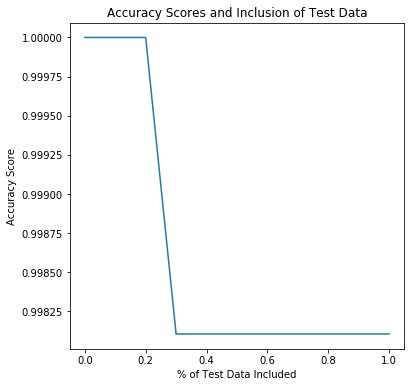

In [111]:
# Set Plot Size
plt.figure(figsize = (6,6))

# Give the plot a title
plt.title("Accuracy Scores and Inclusion of Test Data")
plt.ylabel("Accuracy Score")
plt.xlabel("% of Test Data Included")

# Plot
plt.plot([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], accuracy_scores)

#### At a certain point, including test predictions that we don't have decreasing confidence in results in a lower accuracy score. It makes sense that the more we include of low probability predictions, the worse our accuracy would get because we are including 'training labels' which are actually predictions on data that we had a very low prediction probability for.

### 16 - Use the Model Trained on Entirety of the Training & Test Data & Generate Labels for Test Data

In [112]:
# Predict values for the test data and save the outcome in all upper case
final_predictions_alltraintestobs = pd.Series(round11[0].predict(X_test))
final_predictions_alltraintestobs = final_predictions_alltraintestobs.apply(lambda x: x.upper())
final_predictions_alltraintestobs = final_predictions_alltraintestobs.apply(lambda x: x.replace("'", ""))
final_predictions_alltraintestobs.value_counts()

WARREN       17
BUTTIGIEG    14
HARRIS       12
KLOBUCHAR    11
OROURKE      11
BIDEN        11
SANDERS      11
BOOKER       10
GABBARD       5
STEYER        4
CASTRO        3
YANG          2
dtype: int64

In [113]:
final_predictions.value_counts()

WARREN       28
BUTTIGIEG    14
BIDEN        13
SANDERS      13
BOOKER       10
KLOBUCHAR    10
HARRIS        7
OROURKE       6
GABBARD       4
STEYER        3
YANG          2
CASTRO        1
dtype: int64

#### Our two models have pretty different predictions. Below, I wrote them both to a tab delimited txt file.

In [114]:
with open("problemset3predictions.txt", "w") as file:
    writer = csv.DictWriter(file, fieldnames = ['FILE','MODEL1', 'MODEL2'], delimiter = '\t')
    writer.writeheader()
    for i in range(len(final_predictions)):
        writer.writerow({'FILE':test_files[i],'MODEL1':final_predictions[i], 'MODEL2':final_predictions_alltraintestobs[i]})

In [115]:
# Check that the tab delimited file worked properly
pd.read_csv('problemset3predictions.txt', sep = '\t')

,FILE,MODEL1,MODEL2
0,test_1.txt,WARREN,BUTTIGIEG
1,test_10.txt,BIDEN,BIDEN
2,test_100.txt,STEYER,STEYER
3,test_101.txt,SANDERS,HARRIS
4,test_102.txt,BUTTIGIEG,BUTTIGIEG
...,...,...,...
106,test_95.txt,GABBARD,GABBARD
107,test_96.txt,BOOKER,BOOKER
108,test_97.txt,HARRIS,HARRIS
109,test_98.txt,KLOBUCHAR,KLOBUCHAR


# ----------------------------------------------------------------------------------------------------
## Sources
#### 1. .argsort() method and accompanying filtering and ordering: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
#### 2. Details on Complement Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB
#### 3. Towards Data Science Naive Bayes: https://towardsdatascience.com/introduction-to-na%C3%AFve-bayes-classifier-fa59e3e24aaf
# ----------------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------
## Annex

## ----------------------------------------------------------------------------------------------------------------------
### Question 2: Distribution Analysis

In [115]:
# Calculate length of each sentence and add it to the dataframe
speakers_quotes_df_training['len'] = [len(i.split()) for i in speakers_quotes_df_training['Quotes']]
speakers_quotes_df_training.sample(5)

,Speakers,Quotes,len
420,Warren,We live in a country now where the president i...,99
492,Warren,"What do these issues have in common? Well, fir...",136
149,Buttigieg,"Well, the constitutional process of impeachmen...",179
413,Steyer,"Look, I agree with Elizabeth Warren that, in f...",215
390,Sanders,To the original point. The American people und...,110


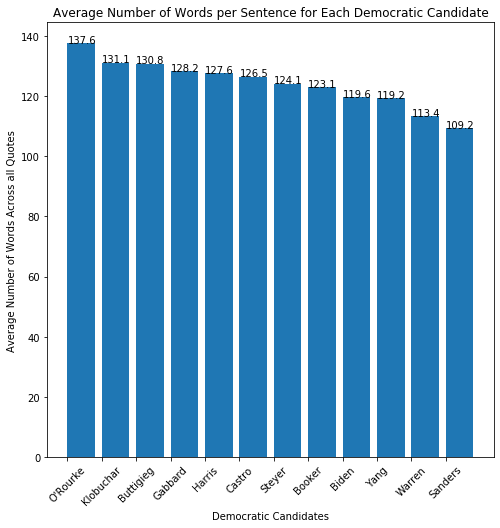

In [116]:
# Calculate mean length of quotes by speaker using group by
mean_len = speakers_quotes_df_training.groupby(['Speakers'], as_index = False).mean()
mean_len.sort_values(by = 'len', ascending = False, inplace = True)

# Set Plot Size
plt.figure(figsize = (8,8))

# Give the plot a title
plt.title("Average Number of Words per Sentence for Each Democratic Candidate")
plt.ylabel("Average Number of Words Across all Quotes")
plt.xlabel("Democratic Candidates")
# Rotate the tick labels and set their alignment.
plt.xticks(rotation=45)

# Use a bar plot
plt.bar(mean_len['Speakers'], mean_len['len'], align = 'edge')

# Label the bar plot with the quote counts
for i in range(len(mean_len)):
    plt.annotate(str(round(mean_len['len'][i],1)), xy=(mean_len['Speakers'][i], mean_len['len'][i]))

#### The plot of the average number of words a decently strong clustering around the mean. However, it is noteworthy that two of the candidate with the most number of sentences (Biden) has the shortest average quote length - he speak frequently but in shorter utterances.
#### Next, let's take a look at the total number of words spoken by each candidate.

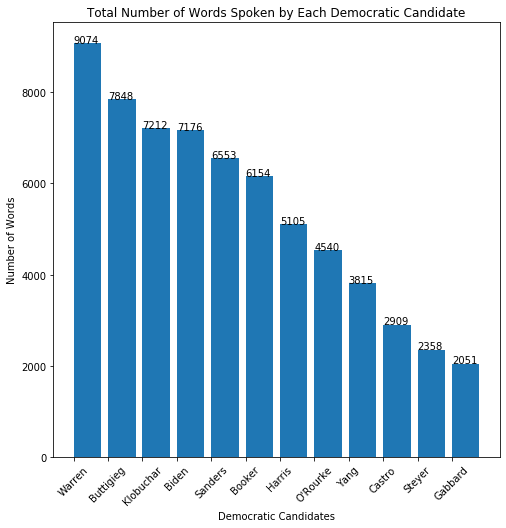

In [117]:
# Show the total number of words spoken for each candidate
num_words = speakers_quotes_df_training.groupby(['Speakers'], as_index = False).sum()
num_words = num_words.sort_values(by='len', ascending = False).reset_index(drop = True)
#num_words = num_words.reset_index

# Set Plot Size
plt.figure(figsize = (8,8))

# Use a bar plot
plt.bar(num_words['Speakers'], num_words['len'], align = 'edge')

# Give the plot a title
plt.title("Total Number of Words Spoken by Each Democratic Candidate")
plt.ylabel("Number of Words")
plt.xlabel("Democratic Candidates")
# Rotate the tick labels and set their alignment.
plt.xticks(rotation=45)

# Label the bar plot with the quote lengths
for i in range(len(num_words)):
    plt.annotate(str(num_words.len[i]), xy=(num_words.Speakers[i], num_words.len[i]))

#### We can see that there is high variation in the number of words spoken by each candidate, and that Warren has thousands of more than Gabbard, but it is difficult to tell how everyone else compares. We can check that, but comparing the total number of words (in the thousands) with the number of sentences (in the hundreds) will be difficult to visualize, so we will need to scale the variables.

In [118]:
# First, add the quotecounts to the num_words dataframe.
# Need to sort the axes so that we can add the quotecounts Series to the dataframe
num_words.sort_values(by = 'Speakers', ascending = False, inplace = True)
num_words = num_words.set_index(num_words['Speakers'])

# Sort the index of the series to that it matches the dataframe
sentencecounts = sentencecounts.sort_index(ascending=False)

# Add the num quotes column to the df
num_words['num sentences'] = sentencecounts

In [119]:
# Now we can apply a min/max scaler to the len and num_quotes columns
num_words = num_words.iloc[:,1:].apply(lambda x: x/x.max(), axis=0)
num_words.sort_values(by = 'len', ascending = False, inplace = True)
num_words

,len,num sentences
Speakers,,
Warren,1.000000,1.000000
Buttigieg,0.864889,0.711730
Klobuchar,0.794798,0.771372
Biden,0.790831,0.874751
Sanders,0.722173,0.652087
Booker,0.678201,0.570577
Harris,0.562596,0.435388
O'Rourke,0.500331,0.389662
Yang,0.420432,0.349901


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

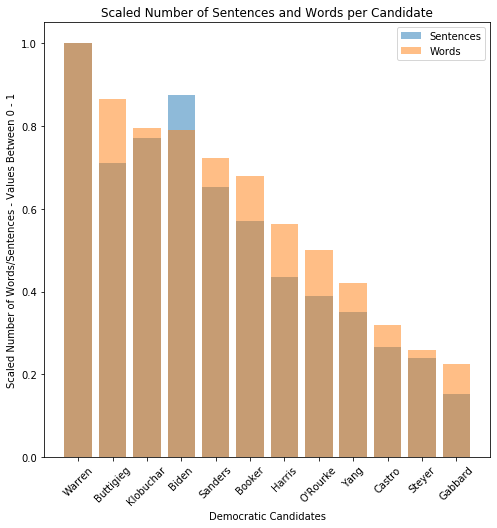

In [120]:
# Set plot size
plt.figure(figsize=(8, 8))

# Give the plot titles and labels
plt.title("Scaled Number of Sentences and Words per Candidate")
plt.xlabel("Democratic Candidates")
plt.ylabel("Scaled Number of Words/Sentences - Values Between 0 - 1")

plt.bar(num_words.index, num_words['num sentences'], label = 'Sentences', alpha = .5)
plt.bar(num_words.index, num_words['len'], label = 'Words', alpha = .5)
legend = plt.legend(loc='upper right')
plt.xticks(rotation=45)

#### I don't know what to call this graph, and it isn't beautiful, but it does reveal a couple of things. We can compare the number of sentences vs the number of words per candidate on the same chart. The height of the blue bar represents the rescaled number of sentences (between 0 and 1) and the orange bar shows the rescaled number of words spoken (also between 0 and 1). These rescaled values are almost like rankings. 
#### I was specifically looking for any cases where one cadidate had a small orange(blue) bar and a very large blue(orange) bar in case they were not represented very strongly in the number of words(sentences) but in a sense 'made up for it' by having a high number of qsentences(words). That is not the case, as the difference between the blue and orange bars in most cases is minor and follows a decreasing pattern (Gabbard's orange and blue bar is less than Steyer's oragen adn blue whose is less than Castro's on and on until Biden). There is some variation near the top with candidates like Buttigieg and Klobuchar who had a smaller number of longer quotes, but they are well represented in both the number of quotes/observations and the number of words spoken. Interestingly, Biden is the only candidate who had relatively more sentences than words, and this reflects him having the lowest averge quote length (i.e. he speaks frequently but in short sentences).
#### We can see that Warren had the highest number of sentences and words - she is very strongly represented in the training part of our corpus. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

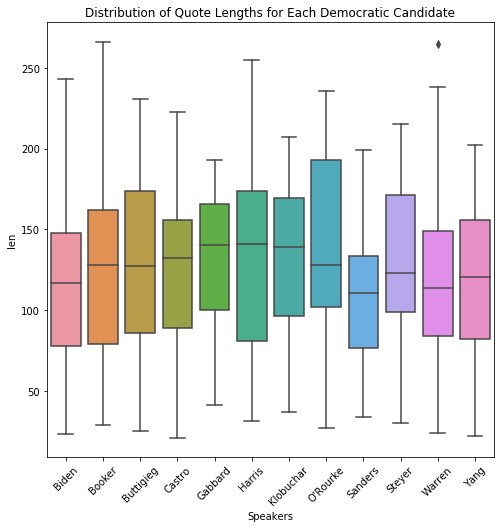

In [121]:
# For fun, let's look at the distribtuion of the quote length for each candidate
# Set plot size
plt.figure(figsize=(8, 8))

# Give the plot titles and labels
plt.title("Distribution of Quote Lengths for Each Democratic Candidate")
plt.xlabel('Democratic Candidates')
plt.ylabel('Quote Lengths')

sns.boxplot(x='Speakers', y="len", data=speakers_quotes_df_training)
plt.xticks(rotation=45)

#### Many candidates average quote length is roughly similar, and this graph is not very revealing. We can see that Warren had one outlier quote - let's print that out and see what it was.

In [122]:
#speakers_quotes_df_training.sort_values(by = 'len').tail()
speakers_quotes_df_training['Quotes'][428]

'From the time I was seven years old, I had a dream. I wanted to be a public school teacher, but my daddy ended up as a janitor and by the time I graduated from high school, my family didn’t have the money to send me off to college. My big chance, was what was then, a commuter college that cost $50 a semester. For me, what this election is all about, is opportunity. Every budget, every policy that we talk about, is about who’s going to get opportunity. Is it gonna go to the billionaires or is it gonna go to our kids? Right now for decades, we have had a government that has been on the side of the rich and the powerful. It has been on the side of the wealthy. And that means it has not been on the side of everyone else. Not on the side of people living on our Native American reservations, people living in inner cities, people living in small farms, and small communities across this country. How do we beat it? We beat it by being the party of big structural change. Give people a reason to

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

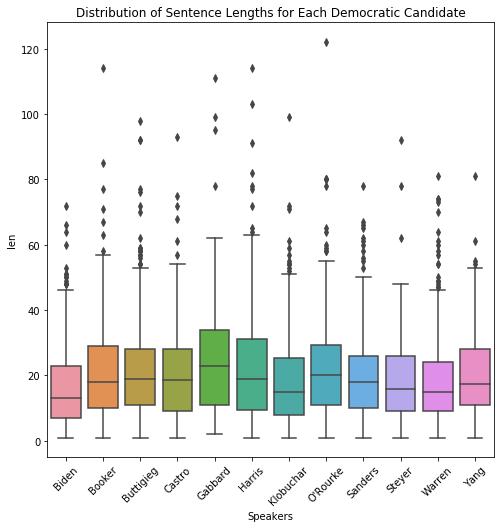

In [123]:
# For fun, let's look at the distribtuion of the sentence length for each candidate
# Set plot size
plt.figure(figsize=(8, 8))

# Give the plot titles and labels
plt.title("Distribution of Sentence Lengths for Each Democratic Candidate")
plt.xlabel('Democratic Candidates')
plt.ylabel('Sentence Lengths')

speakers_sentences_df_training['len'] = [len(i.split()) for i in speakers_sentences_df_training['Sentence']]

sns.boxplot(x='Speakers', y="len", data=speakers_sentences_df_training)
plt.xticks(rotation=45)

#### Many candidates average sentence length is roughly similar, but we can see that most had some 'rants' shown by the large number of outlier sentence lengths.

## ----------------------------------------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------------------------------------
### Question 5: Tokenize Words

Text(0, 0.5, 'Number of Words')

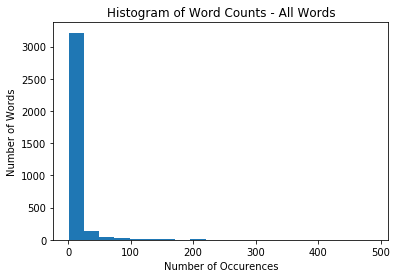

In [124]:
plt.hist(word_counts, bins = 20)
plt.title('Histogram of Word Counts - All Words')
plt.xlabel('Number of Occurences')
plt.ylabel('Number of Words')

#### Looks like there is a high concentration around 0, let's focus in there.

Text(0, 0.5, 'Number of Words')

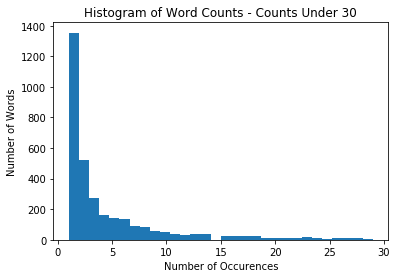

In [125]:
few_words = word_counts[word_counts < 30]
plt.hist(few_words, bins = 30)
plt.title('Histogram of Word Counts - Counts Under 30')
plt.xlabel('Number of Occurences')
plt.ylabel('Number of Words')

Text(0, 0.5, 'Number of Words')

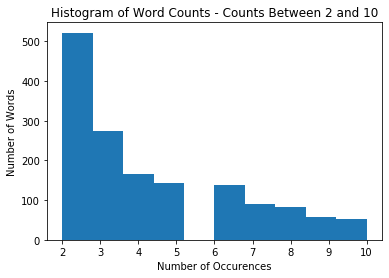

In [126]:
majority_of_words = word_counts[word_counts <= 10]
morethan1 = majority_of_words[majority_of_words > 1]
plt.hist(morethan1)
plt.title('Histogram of Word Counts - Counts Between 2 and 10')
plt.xlabel('Number of Occurences')
plt.ylabel('Number of Words')

## ----------------------------------------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------------------------------------
### Question 6: CountVectorizer

In [127]:
# Create new instance of CountVectorizer
testvec = CountVectorizer()
# Fit the CountVectorizer on the test data
testvec.fit(test_data_cleaned)
# Extract the tokens or vocab
testwords = testvec.get_feature_names()
len(testwords)

1715

#### The test dataset only has 1,721 words compared to the 3,469 in the training set. Howver, because we fit the CountVectorizer on the training set and used that fit for the test data, the test sparse array has 3,469 colulmns just like the training set.

## ----------------------------------------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------------------------------------
### Question 7: Additional Models

### Same Models as Before, Now With TFIDF

In [128]:
# Tune the hyperparameter C
logregmods_ridge_tfidf = []
for i in np.arange(.001,1,.1):
    logregmods_ridge_tfidf.append(LogisticRegression(penalty = 'l2', multi_class = 'ovr', solver = 'liblinear', C=i).fit(X_tfidf,y))

results_ridge_tfidf = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_ridge_tfidf, X_tfidf),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_ridge_tfidf.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,C
0,Biden,0.0,NaN,NaN,0.001
1,Booker,0.0,NaN,NaN,0.001
2,Buttigieg,0.0,NaN,NaN,0.001
3,Castro,0.0,NaN,NaN,0.001
4,Gabbard,0.0,NaN,NaN,0.001


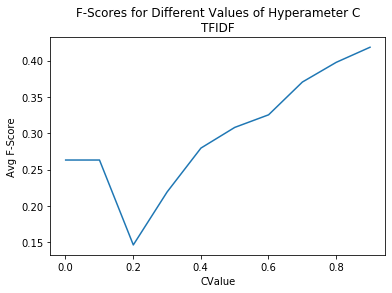

In [129]:
# Group the results by the C value and calculate mean scores
grouped_results_ridge_tfidf = results_ridge_tfidf.groupby('C', as_index = False).mean()
plot_f_score(grouped_results_ridge_tfidf, 'C', 'F-Scores for Different Values of Hyperameter C\nTFIDF')

#### Doesn't look better than the ridge regression with unigrams or bigrams.
#### Bagging with TFIDF.

In [130]:
# Tune the hyperparameter Number of Estimators
bagging_mods_tfidf = []
for i in np.arange(1,200,20):
    bagging_mods_tfidf.append(BaggingClassifier(base_estimator = decisiontree, n_estimators=i).fit(X_tfidf,y))
    
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
bagging_results_tfidf = many_model_scores(conf_mat_preds = cross_validated_many_preds(bagging_mods_tfidf, X_tfidf),
                  hyperparams = np.arange(1,200,20), 
                  hyperparam_name = 'Number of Estimators')

bagging_results_tfidf.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Candidate,Recall,Precision,F-Score,Number of Estimators
0,Biden,0.20,0.307692,0.242424,1
1,Booker,0.16,0.109589,0.130081,1
2,Buttigieg,0.05,0.142857,0.074074,1
3,Castro,0.00,NaN,NaN,1
4,Gabbard,0.00,NaN,NaN,1


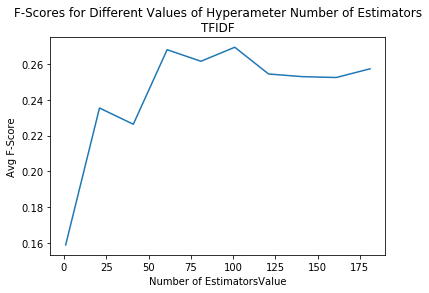

In [131]:
# Group the results by the C value and calculate mean scores
grouped_results_bagging_tfidf = bagging_results_tfidf.groupby('Number of Estimators', as_index = False).mean()
plot_f_score(grouped_results_bagging_tfidf, 'Number of Estimators', 'F-Scores for Different Values of Hyperameter Number of Estimators\nTFIDF')

#### Not much of a difference between bagging with tfidf or with bigrams or unigrams
#### CNB with TFIDF.

In [132]:
# Tune the hyperparameter alpha. Using quotecounts as the priors (although this doesn't seem to affect things)
cnb_mods_tfidf = []
for i in np.arange(.01,5,.5):
    cnb_mods_tfidf.append(ComplementNB(class_prior = sentencecounts ,alpha=i).fit(X_tfidf,y))

# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_cnb_tfidf = many_model_scores(conf_mat_preds = cross_validated_many_preds(cnb_mods_tfidf, X_tfidf),
                  hyperparams = np.arange(.01,5,.5), 
                  hyperparam_name = 'Alpha')

results_cnb_tfidf.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Candidate,Recall,Precision,F-Score,Alpha
0,Biden,0.450000,0.442623,0.446281,0.01
1,Booker,0.360000,0.486486,0.413793,0.01
2,Buttigieg,0.516667,0.484375,0.500000,0.01
3,Castro,0.043478,0.062500,0.051282,0.01
4,Gabbard,0.375000,0.333333,0.352941,0.01


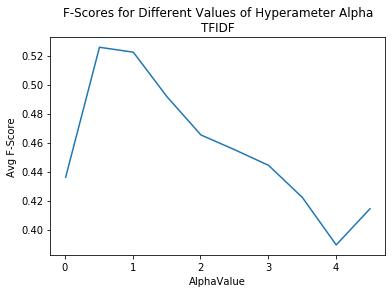

In [133]:
# Group the results by the C value and calculate mean scores
grouped_results_cnb_tfidf = results_cnb_tfidf.groupby('Alpha', as_index = False).mean()
plot_f_score(grouped_results_cnb_tfidf, 'Alpha', 'F-Scores for Different Values of Hyperameter Alpha\nTFIDF')

#### The CNB model ith TFID looks like it performs worse with TFIDF than with bigrams and unigrams.
### Same Models as Before, Now With Min Word Counts > 1

In [134]:
# Tune the hyperparameter C
logregmods_ridge_highcounts = []
for i in np.arange(.001,1,.1):
    logregmods_ridge_highcounts.append(LogisticRegression(penalty = 'l2', multi_class = 'ovr', solver = 'liblinear', C=i).fit(X_highcounts,y))

results_ridge_highcounts = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_ridge_highcounts, X_highcounts),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_ridge_highcounts.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,C
0,Biden,0.483333,0.547170,0.513274,0.001
1,Booker,0.080000,0.666667,0.142857,0.001
2,Buttigieg,0.416667,0.290698,0.342466,0.001
3,Castro,0.000000,NaN,NaN,0.001
4,Gabbard,0.000000,NaN,NaN,0.001


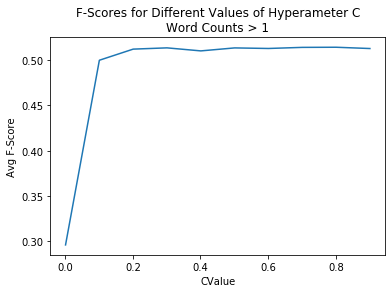

In [135]:
# Group the results by the C value and calculate mean scores
grouped_results_ridge_highcounts = results_ridge_highcounts.groupby('C', as_index = False).mean()
plot_f_score(grouped_results_ridge_highcounts, 'C', 'F-Scores for Different Values of Hyperameter C\nWord Counts > 1')

#### Looks like ridge regression with min word counts > 1 performs a bit better than with tfidf or with unigrams or bigrams.
#### Bagging with Min Word Counts > 1.

In [136]:
# Tune the hyperparameter Number of Estimators
bagging_mods_highcounts = []
for i in np.arange(1,200,20):
    bagging_mods_highcounts.append(BaggingClassifier(base_estimator = decisiontree, n_estimators=i).fit(X_highcounts,y))
    
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
bagging_results_highcounts = many_model_scores(conf_mat_preds = cross_validated_many_preds(bagging_mods_highcounts, X_highcounts),
                  hyperparams = np.arange(1,200,20), 
                  hyperparam_name = 'Number of Estimators')

bagging_results_highcounts.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,Number of Estimators
0,Biden,0.133333,0.400000,0.200000,1
1,Booker,0.060000,0.214286,0.093750,1
2,Buttigieg,0.016667,0.125000,0.029412,1
3,Castro,0.000000,0.000000,NaN,1
4,Gabbard,0.000000,0.000000,NaN,1


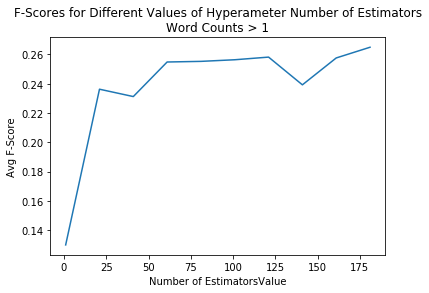

In [137]:
# Group the results by the C value and calculate mean scores
grouped_results_bagging_highcounts = bagging_results_highcounts.groupby('Number of Estimators', as_index = False).mean()
plot_f_score(grouped_results_bagging_highcounts, 'Number of Estimators', 'F-Scores for Different Values of Hyperameter Number of Estimators\nWord Counts > 1')

#### Not much of a difference between bagging with tfidf or with bigrams or unigrams
#### CNB with Min Word Counts > 1.

In [138]:
# Tune the hyperparameter alpha. Using quotecounts as the priors (although this doesn't seem to affect things)
cnb_mods_highcounts = []
for i in np.arange(.01,5,.5):
    cnb_mods_highcounts.append(ComplementNB(class_prior = sentencecounts ,alpha=i).fit(X_highcounts,y))

# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_cnb_highcounts = many_model_scores(conf_mat_preds = cross_validated_many_preds(cnb_mods_highcounts, X_highcounts),
                  hyperparams = np.arange(.01,5,.5), 
                  hyperparam_name = 'Alpha')

results_cnb_highcounts.head()

,Candidate,Recall,Precision,F-Score,Alpha
0,Biden,0.433333,0.448276,0.440678,0.01
1,Booker,0.340000,0.425000,0.377778,0.01
2,Buttigieg,0.566667,0.472222,0.515152,0.01
3,Castro,0.043478,0.062500,0.051282,0.01
4,Gabbard,0.375000,0.352941,0.363636,0.01


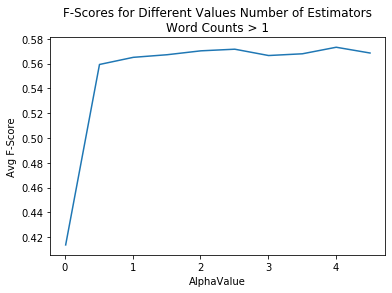

In [139]:
# Group the results by the C value and calculate mean scores
grouped_results_cnb_highcounts = results_cnb_highcounts.groupby('Alpha', as_index = False).mean()
plot_f_score(grouped_results_cnb_highcounts, 'Alpha', 'F-Scores for Different Values Number of Estimators\nWord Counts > 1')

#### PCA

In [140]:
# Tune the hyperparameter C
logregmods_ridge_pca = []
for i in np.arange(.001,1,.1):
    logregmods_ridge_pca.append(LogisticRegression(penalty = 'l2', multi_class = 'ovr', solver = 'liblinear', C=i).fit(X_reduced,y))

results_ridge_pca = many_model_scores(conf_mat_preds = cross_validated_many_preds(logregmods_ridge_pca, X_reduced),
                  hyperparams = np.arange(.001,1,.1), 
                  hyperparam_name = 'C')

results_ridge_pca.head()

,Candidate,Recall,Precision,F-Score,C
0,Biden,0.700000,0.488372,0.575342,0.001
1,Booker,0.320000,0.432432,0.367816,0.001
2,Buttigieg,0.450000,0.397059,0.421875,0.001
3,Castro,0.130435,0.750000,0.222222,0.001
4,Gabbard,0.312500,0.625000,0.416667,0.001


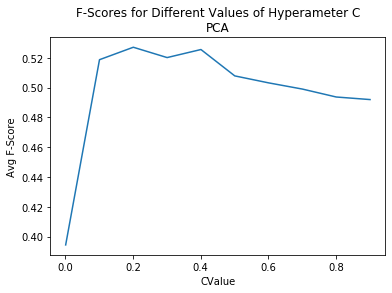

In [141]:
# Group the results by the C value and calculate mean scores
grouped_results_ridge_pca = results_ridge_pca.groupby('C', as_index = False).mean()
plot_f_score(grouped_results_ridge_pca, 'C', 'F-Scores for Different Values of Hyperameter C\nPCA')

In [142]:
# Tune the hyperparameter Number of Estimators
bagging_mods_pca = []
for i in np.arange(1,200,20):
    bagging_mods_pca.append(BaggingClassifier(base_estimator = decisiontree, n_estimators=i).fit(X_reduced,y))
    
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
bagging_results_pca = many_model_scores(conf_mat_preds = cross_validated_many_preds(bagging_mods_pca, X_reduced),
                  hyperparams = np.arange(1,200,20), 
                  hyperparam_name = 'Number of Estimators')

bagging_results_pca.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  


,Candidate,Recall,Precision,F-Score,Number of Estimators
0,Biden,0.133333,0.125000,0.129032,1
1,Booker,0.140000,0.102941,0.118644,1
2,Buttigieg,0.216667,0.173333,0.192593,1
3,Castro,0.000000,0.000000,NaN,1
4,Gabbard,0.000000,0.000000,NaN,1


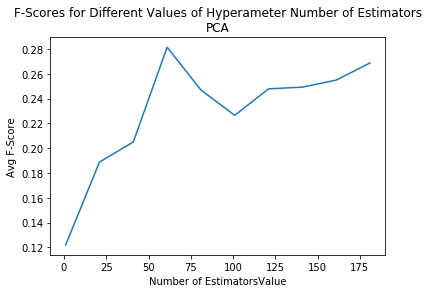

In [143]:
# Group the results by the C value and calculate mean scores
grouped_results_bagging_pca = bagging_results_pca.groupby('Number of Estimators', as_index = False).mean()
plot_f_score(grouped_results_bagging_pca, 'Number of Estimators', 'F-Scores for Different Values of Hyperameter Number of Estimators\nPCA')

#### Naive Bayes doesn't take negative values and the PCA has negative values, so I square and then square root them

In [144]:
# Tune the hyperparameter alpha. Using quotecounts as the priors (although this doesn't seem to affect things)
cnb_mods_pca = []
for i in np.arange(.01,5,.5):
    cnb_mods_pca.append(ComplementNB(class_prior = sentencecounts, alpha=i).fit(np.sqrt(X_reduced**2),y))

# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results_cnb_pca = many_model_scores(conf_mat_preds = cross_validated_many_preds(cnb_mods_pca, np.sqrt(X_reduced**2)),
                  hyperparams = np.arange(.01,5,.5), 
                  hyperparam_name = 'Alpha')

results_cnb_pca.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Candidate,Recall,Precision,F-Score,Alpha
0,Biden,0.166667,0.163934,0.165289,0.01
1,Booker,0.120000,0.176471,0.142857,0.01
2,Buttigieg,0.233333,0.191781,0.210526,0.01
3,Castro,0.000000,0.000000,NaN,0.01
4,Gabbard,0.000000,0.000000,NaN,0.01


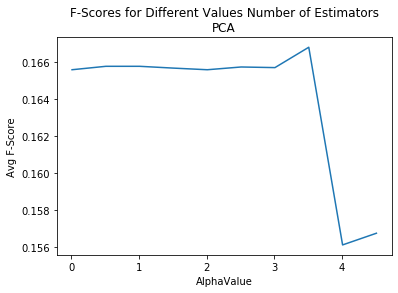

In [145]:
# Group the results by the C value and calculate mean scores
grouped_results_cnb_pca = results_cnb_pca.groupby('Alpha', as_index = False).mean()
plot_f_score(grouped_results_cnb_pca, 'Alpha', 'F-Scores for Different Values Number of Estimators\nPCA')

#### Let's take a look at the best model in each class, using unigrams, bigrams, tfidf, and the matrix where words with a count of 1 are excluded.

In [146]:
# CNB Model
print(grouped_results_cnb_tfidf['F-Score'].max(), 
      grouped_results_cnb['F-Score'].max(), 
      grouped_results_cnb_bigram['F-Score'].max(),
      grouped_results_cnb_highcounts['F-Score'].max(),
      grouped_results_cnb_pca['F-Score'].max())

0.5257332547710113 0.5678037038918541 0.5961951563876509 0.5731921949822473 0.16678376807421558


In [147]:
# Bagging Model
print(grouped_results_bagging_tfidf['F-Score'].max(), 
      grouped_results_bagging['F-Score'].max(), 
      grouped_results_bagging_bigram['F-Score'].max(),
      grouped_results_bagging_highcounts['F-Score'].max(),
      grouped_results_bagging_pca['F-Score'].max())

0.26937971360624613 0.27667174927820426 0.2851754859585832 0.26484515649145335 0.2814105873938599


In [148]:
# Ridge Model
print(grouped_results_ridge_tfidf['F-Score'].max(), 
      grouped_results_ridge['F-Score'].max(), 
      grouped_results_ridge_bigram['F-Score'].max(),
      grouped_results_ridge_highcounts['F-Score'].max(),
      grouped_results_ridge_pca['F-Score'].max())

0.418452062337781 0.5137314623374191 0.5325327133312234 0.514367492819159 0.5271383408255953


## ----------------------------------------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------------------------------------
### Question 8: Logistic Regression

In [149]:
# Start by calculating the predictions and prediction probabilities
logpreds = logreg.predict(X)
logprobpreds = logreg.predict_proba(X)

# Get the highest (max) probability for each prediction
max_prob_pred = pd.Series([max(i) for i in logprobpreds])

# Create a boolean mask for when the max prediction is under 30% and another mask for over 94%
low_mask = [max_prob_pred[i] < .3 for i in range(len(max_prob_pred))]
high_mask = [max_prob_pred[i] > .94 for i in range(len(max_prob_pred))]

# Use those masks to select only the observations that meet that criteria
low_prob_preds = max_prob_pred[low_mask]
high_prob_preds = max_prob_pred[high_mask]

In [150]:
for i in low_prob_preds.index:
    print(training_data_cleaned[i],'\n')

never count profession setback seriou setback thing import thing unimport 

point one reason pick vice presid relationship longstand relat black commun part coalit 

women daughter friend wive women deserv control bodi 

first time american histori fall sent children school strongest nation planet earth said protect 

school go teach hide duck cover drill shelter place drill america fire drill 

let tell marijuana countri alreadi legal privileg war drug war black brown 

process issu alway fashion must act reform democraci includ come choos presid 

want make sure lift famili work need help expand earn incom tax credit 

categor charter school requir transpar account requir right 

seem abl join rule appli twitter way facebook 

peac plan call mandatori buyback let follow inspir lead limit poll consult focu group let 

talk progress agenda win vote democrat ever way defeat donald trump novemb 2020 

exactli parent taught take biggest problem america directli fight everi singl day 

dou

In [151]:
for i in high_prob_preds.index:
    print(training_data_cleaned[i],'\n')

watch know job engag look one reason run age experi come wisdom need someon take offic time around day one stand world stage command respect world leader putin alli know exactli done countri back track requir time lifetim someon capac day one one reason decid run decid run time know done done pull nation worst financi recess histori got mani piec legisl pass includ afford care act well make sure recoveri act kept go depress know done need on-the-job train day take offic releas medic record 21 year tax record one els stage done full transpar health 

well look next presid unit state go two thing defeat donald trump number one number two go abl go state georgia north carolina place senat major ask abl win nomin first place win presid first place secondli increas number democrat hous senat way learn someth impeach trial learn number one donald trump want nomine pretti clear held aid make sure time innoc donbass kill russian soldier secondli found vladimir putin want presid learn lot thing

#### One obvious difference is the length of the quotes.

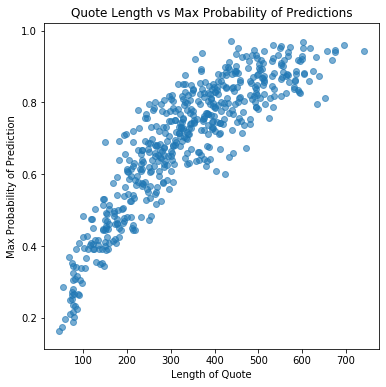

In [152]:
# Set Plot Size
plt.figure(figsize = (6,6))

# Give the plot a title
plt.title("Quote Length vs Max Probability of Predictions")
plt.ylabel("Max Probability of Prediction")
plt.xlabel("Length of Quote")
plt.scatter(pd.Series([len(i) for i in training_data_cleaned]), max_prob_pred, alpha = .6)

## ----------------------------------------------------------------------------------------------------------------------

## ----------------------------------------------------------------------------------------------------------------------
### Question 9: Tree-Based Methods

In [153]:
# Tune the hyperparameter n_estimators
boosting_mods = []
for i in np.arange(1,1000,100):
    boosting_mods.append(AdaBoostClassifier(n_estimators=i).fit(X,y))

In [154]:
# Using the helper functions created above, we can pass in the different models, generate predictions,
# use those predictions to build confusion matrices, and store the results of some of the values
# like precision, recall, and f-score from those confusion matrices in a data frame.
results = many_model_scores(conf_mat_preds = cross_validated_many_preds(boosting_mods, X),
                  hyperparams = np.arange(1,1000,100), 
                  hyperparam_name = 'Number of Estimators')

results.head()

C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in longlong_scalars
  
C:\Users\John\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


,Candidate,Recall,Precision,F-Score,Number of Estimators
0,Biden,0.05,0.428571,0.089552,1
1,Booker,0.00,NaN,NaN,1
2,Buttigieg,0.00,NaN,NaN,1
3,Castro,0.00,NaN,NaN,1
4,Gabbard,0.00,NaN,NaN,1


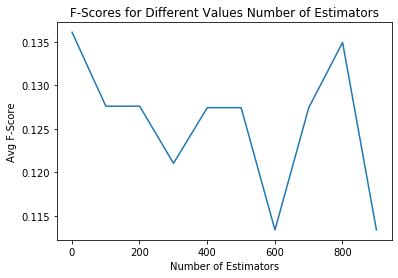

In [155]:
# Group the results by the C value and calculate mean scores
grouped_results_boosting = results.groupby('Number of Estimators', as_index = False).mean()

# Plot the results for mean F-Scores
plt.title('F-Scores for Different Values Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Avg F-Score')
plt.plot('Number of Estimators', 'F-Score', data = grouped_results_boosting)

In [156]:
# Show the num_estimator value that corresponds to the highest F-Score
grouped_results_boosting[grouped_results_boosting['F-Score'] == grouped_results_boosting['F-Score'].max()]

,Number of Estimators,Recall,Precision,F-Score
0,1,0.088984,0.277125,0.136088


In [157]:
# Use that model to generate cross-validated predictions
cv_y_pred = cross_val_predict(boosting_mods[-1], X, y, cv = 5)

# Create a multi-class confusion_matrix from those preidctions
conf_mat = confusion_matrix(y, cv_y_pred, labels = pd.Series(y).unique())

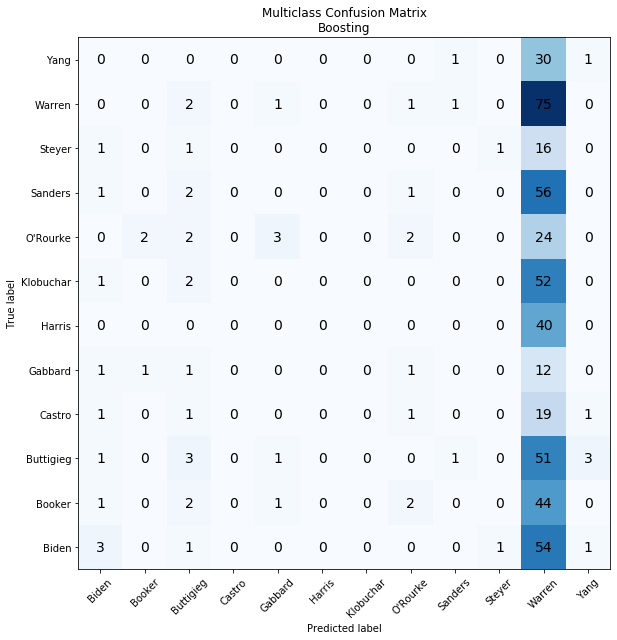

In [158]:
plot_confusion_matrix(conf_mat, 
                      classes=np.array(pd.Series(y).unique()),
                      title = 'Multiclass Confusion Matrix\nBoosting')

## ----------------------------------------------------------------------------------------------------------------------

# ----------------------------------------------------------------------------------------------------

#### Each observation (quote) can be multiple sentences, and because we only have 528 quotes, it will be challenging to build a model on so few observations, especially since the number of features (unique words) will be large and probably larger than the number of observations. To counter this, I will split each quote into individual sentences. I'll also need to expand the list of speakers by the exact number of sentences for each quote so that the speaker names are tied to each sentence. The function below does exactly that.

In [159]:
# USED WHEN SPLITTING INTO SENTENCES

"""# Send the test data through the clean_quotes function
#test_data_cleaned = clean_quotes(speakers_quotes_df_test['Sentence'])"""

"""y = speakers_quotes_df_training['Speakers']"""

# Create file names since we have 669 instead of 111 files
"""filenames = []
for i in range(1,670):
    filenames.append('test_'+str(i)+'.txt')"""

"filenames = []\nfor i in range(1,670):\n    filenames.append('test_'+str(i)+'.txt')"